# Sequencing artifacts detection with beta binomial distribution

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import json
pd.set_option('display.max_columns', 500)
tqdm.pandas()

## Analysis on blood samples from other patients


Check all mutations if they are present in other normal tissues from other patients sequenced at the same batch.  
Create a binomial distribution of each mutation with the data from the other normal samples.  
If the mutation is following a binomial distribution, we remove it. It is likely to be an artifact.  

These bam files are not part of the dataset available in EGA. These are bam files from other pediatric patients analysed in our lab, and here are used to detect possible sequencing artifacts (common mutations shared between non-related individuals). To get access to these files please contact bbglab@irbbarcelona.org

In [2]:
blood_suffixes_dict = {'AQ5174':'_b1',
                        'AQ5175':'_b2',
                        'AQ5176':'_b3',
                        'AQ5177':'_b4',
                        'AQ5178':'_b5',
                        'AQ5179':'_b6',
                        'AW8058':'_b7',
                        'AW8061':'_b8',
                        'AW8059':'_b9',
                        'AW8060':'_b10',
                        'AX4894':'_b11',
                        'AX4895':'_b12',
                        'AX4896':'_b13',
                        'AX4897':'_b14',
                        'AX4898':'_b15',
                       'AX4899':'_b16',
                       'AX4900':'_b17',
                       'AX4901':'_b18',
                       'AX4904':'_b19',
                       'AX4905':'_b20',
                       'AX4906':'_b21',
                       'AX4907':'_b22',
                       'AX4908':'_b23',
                       'AX4909':'_b24',
                       'AX4910':'_b25',
                       'AX4911':'_b26'
                }

In [3]:
blood_samples_dict = {'AQ5174': 'blood1',
                     'AQ5175': 'blood2',
                     'AQ5176': 'blood3',
                     'AQ5177': 'blood4',
                     'AQ5178': 'blood5',
                     'AQ5179': 'blood6',
                     'AW8058': 'blood7',
                     'AW8061': 'blood8',
                     'AW8059': 'blood9',
                     'AW8060': 'blood10',
                     'AX4894': 'blood11',
                     'AX4895': 'blood12',
                     'AX4896': 'blood13',
                     'AX4897': 'blood14',
                     'AX4898': 'blood15',
                     'AX4899': 'blood16',
                     'AX4900': 'blood17',
                     'AX4901': 'blood18',
                     'AX4904': 'blood19',
                     'AX4905': 'blood20',
                     'AX4906': 'blood21',
                     'AX4907': 'blood22',
                     'AX4908': 'blood23',
                     'AX4909': 'blood24',
                     'AX4910': 'blood25',
                     'AX4911': 'blood26'}

In [4]:
blood_bams_dict = {'AQ5174':'/workspace/datasets/sjd_seq/platinum_results/20220809/pt1-t1-allsamples-t1/AQ5174/aligner/AQ5174.bam',
                 'AQ5175': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt2-t1-allsamples-t1/AQ5175/aligner/AQ5175.bam',
                 'AQ5176': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt3-t1-allsamples-t1/AQ5176/aligner/AQ5176.bam',
                 'AQ5177': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt4-t1-allsamples-t1/AQ5177/aligner/AQ5177.bam',
                 'AQ5178': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt5-t1-allsamples-t1/AQ5178/aligner/AQ5178.bam',
                 'AQ5179': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt6-t1-allsamples-t1/AQ5179/aligner/AQ5179.bam',
                 'AW8058': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt7-t1-allsamples-t1/AW8058/aligner/AW8058.bam',
                 'AW8061': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt8-t1-allsamples-t1/AW8061/aligner/AW8061.bam',
                 'AW8059': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt10-t1-allsamples-t1/AW8059/aligner/AW8059.bam',
                 'AW8060': '/workspace/datasets/sjd_seq/platinum_results/20220809/pt11-t1-allsamples-t1/AW8060/aligner/AW8060.bam',
                 'AX4894': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt1-t1-rhabdoids-t1/AX4894/aligner/AX4894.bam',
                 'AX4895': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt3-t1-rhabdoids-t1/AX4895/aligner/AX4895.bam',
                 'AX4896': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt4-t1-rhabdoids-t1/AX4896/aligner/AX4896.bam',
                 'AX4897': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt5-t1-rhabdoids-t1/AX4897/aligner/AX4897.bam',
                 'AX4898': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt6-t1-rhabdoids-t1/AX4898/aligner/AX4898.bam',
                 'AX4899': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt7-t1-rhabdoids-t1/AX4899/aligner/AX4899.bam',
                 'AX4900': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt8-t1-rhabdoids-t1/AX4900/aligner/AX4900.bam',
                 'AX4901': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt9-t1-rhabdoids-t1/AX4901/aligner/AX4901.bam',
                 'AX4904': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt12-t1-rhabdoids-t1/AX4904/aligner/AX4904.bam',
                 'AX4905': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt13-t1-rhabdoids-t1/AX4905/aligner/AX4905.bam',
                 'AX4906': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt15-t1-rhabdoids-t1/AX4906/aligner/AX4906.bam',
                 'AX4907': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt16-t1-rhabdoids-t1/AX4907/aligner/AX4907.bam',
                 'AX4908': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt17-t1-rhabdoids-t1/AX4908/aligner/AX4908.bam',
                 'AX4909': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt18-t1-rhabdoids-t1/AX4909/aligner/AX4909.bam',
                 'AX4910': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt19-t1-rhabdoids-t1/AX4910/aligner/AX4910.bam',
                 'AX4911': '/workspace/datasets/rhabdoid_tumors/platinum_results/pt20-t1-rhabdoids-t1/AX4911/aligner/AX4911.bam',
                }

In [5]:
mut_df = pd.read_csv('./output/somatic_filtered_vep_hc_mutect.tsv.gz',sep='\t')
mut_df.drop_duplicates(subset=['CHROM','POS','REF','ALT','mut_type'],inplace=True)

#preapre table for blood mut calling
blood_cols = []
mut_blood_df = mut_df[['CHROM','POS','REF','ALT','mut_type']]
mut_blood_df = mut_blood_df[['CHROM','POS','REF','ALT','mut_type']].drop_duplicates()
mut_blood_df.groupby('mut_type').count()

/tmp/jobs/msanchezg/9200712/ipykernel_21999/3751565349.py:1: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df = pd.read_csv('./output/somatic_filtered_vep_hc_mutect.tsv.gz',sep='\t')


,CHROM,POS,REF,ALT
mut_type,,,,
indel,490352,490352,490352,490352
snv,160933,160933,160933,160933


In [6]:
#save necessary json files for running the python script
import json

mut_blood_df.to_csv('./output/somatic_vep_hc_mutect_blood_cols.tsv.gz',sep='\t',compression='gzip',index=None)

with(open('./dictionaries/blood_suffixes_dict.json','w')) as f:
    json.dump(blood_suffixes_dict,f)
with(open('./dictionaries/blood_samples_dict.json','w')) as f:
    json.dump(blood_samples_dict,f)
with(open('./dictionaries/blood_bams_dict.json','w')) as f:
    json.dump(blood_bams_dict,f)

Perform mutation calling of snv/indel muts in blood bams:\
Run scripts to rescue muts, check ```./rescued_muts/``` folder.

In [7]:
#load annotated mutations from normal blood bams
blood_snv_bam_df = pd.read_csv('./rescued_muts/blood_snv_muts_from_bam.tsv.gz',sep='\t')
blood_indel_bam_df = pd.read_csv('./rescued_muts/blood_indel_muts_from_bam.tsv.gz',sep='\t')
blood_bam_df = pd.concat([blood_snv_bam_df,blood_indel_bam_df],ignore_index=True)
blood_bam_df.drop(['AF_b1','ref_reads_b1','alt_reads_b1','DP_b1','blood1'],inplace=True,axis=1)

#some positions are more prone to be mutated
grp_df = blood_bam_df.groupby(['CHROM','POS','REF']).count().sort_values('ALT',ascending=False)
grp_df[grp_df['ALT']>1]

,,,ALT,AF_b2,ref_reads_b2,alt_reads_b2,DP_b2,AF_b3,ref_reads_b3,alt_reads_b3,DP_b3,AF_b4,ref_reads_b4,alt_reads_b4,DP_b4,AF_b5,ref_reads_b5,alt_reads_b5,DP_b5,AF_b6,ref_reads_b6,alt_reads_b6,DP_b6,AF_b7,ref_reads_b7,alt_reads_b7,DP_b7,AF_b8,ref_reads_b8,alt_reads_b8,DP_b8,AF_b9,ref_reads_b9,alt_reads_b9,DP_b9,AF_b10,ref_reads_b10,alt_reads_b10,DP_b10,AF_b11,ref_reads_b11,alt_reads_b11,DP_b11,AF_b12,ref_reads_b12,alt_reads_b12,DP_b12,AF_b13,ref_reads_b13,alt_reads_b13,DP_b13,AF_b14,ref_reads_b14,alt_reads_b14,DP_b14,AF_b15,ref_reads_b15,alt_reads_b15,DP_b15,AF_b16,ref_reads_b16,alt_reads_b16,DP_b16,AF_b17,ref_reads_b17,alt_reads_b17,DP_b17,AF_b18,ref_reads_b18,alt_reads_b18,DP_b18,AF_b19,ref_reads_b19,alt_reads_b19,DP_b19,AF_b20,ref_reads_b20,alt_reads_b20,DP_b20,AF_b21,ref_reads_b21,alt_reads_b21,DP_b21,AF_b22,ref_reads_b22,alt_reads_b22,DP_b22,AF_b23,ref_reads_b23,alt_reads_b23,DP_b23,AF_b24,ref_reads_b24,alt_reads_b24,DP_b24,AF_b25,ref_reads_b25,alt_reads_b25,DP_b25,AF_b26,ref_reads_b26,alt_reads_b26,DP_b26,blood2,blood3,blood4,blood5,blood6,blood7,blood8,blood9,blood10,blood11,blood12,blood13,blood14,blood15,blood16,blood17,blood18,blood19,blood20,blood21,blood22,blood23,blood24,blood25,blood26
CHROM,POS,REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
chr6,159304813,-,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
chr8,61232024,-,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
chr22,32014223,-,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
chr8,41919830,-,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
chr5,171893422,-,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr10,117609762,-,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,

### Run betabinomial test script

Script is ready here:\
`/workspace/projects/sjd_pediatric_tumors/code/filters/calculate_pvals_betabinom.py`

In [8]:
ref_blood_cols = ['ref_reads'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
alt_blood_cols = ['alt_reads'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
DP_blood_cols = ['DP'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
AF_blood_cols = ['AF'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
read_blood_cols = ref_blood_cols + alt_blood_cols + DP_blood_cols + AF_blood_cols

In [13]:
#load mutations data from tissues
mut_df = pd.read_csv('./output/somatic_filtered_vep_hc_mutect.tsv.gz',sep='\t')
mut_df.drop_duplicates(subset=['CHROM','POS','REF','ALT','mut_type'],inplace=True)

#load annotated mutations from normal blood bams
blood_snv_bam_df = pd.read_csv('./rescued_muts/blood_snv_muts_from_bam.tsv.gz',sep='\t')
blood_indel_bam_df = pd.read_csv('./rescued_muts/blood_indel_muts_from_bam.tsv.gz',sep='\t')
blood_bam_df = pd.concat([blood_snv_bam_df,blood_indel_bam_df],ignore_index=True)
blood_cols = [blood_samples_dict[tissue] for tissue in blood_samples_dict.keys() if tissue != 'AQ5174' ]
blood_bam_df.drop(['AF_b1','ref_reads_b1','alt_reads_b1','DP_b1','blood1'],inplace=True,axis=1)

ref_blood_cols = ['ref_reads'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
alt_blood_cols = ['alt_reads'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
DP_blood_cols = ['DP'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
AF_blood_cols = ['AF'+blood_suffixes_dict[sample] for sample in blood_suffixes_dict.keys() if sample != 'AQ5174']
read_blood_cols = ref_blood_cols + alt_blood_cols + DP_blood_cols + AF_blood_cols

suffixes_dict = json.load(open('./dictionaries/suffixes_dict.json','rb'))
alt_reads_cols = ['alt_reads'+suffixes_dict[sample] for sample in suffixes_dict.keys()]
DP_cols = ['DP'+suffixes_dict[sample] for sample in suffixes_dict.keys()]
pvals_cols = ['pval_sa'+suffixes_dict[sample] for sample in suffixes_dict.keys()]

main_cols = ['CHROM','POS','REF','ALT']
mut2_df = pd.merge(mut_df[main_cols+alt_reads_cols+DP_cols],blood_bam_df[main_cols+alt_blood_cols+DP_blood_cols],how='left')
mut2_df.drop_duplicates(inplace=True,subset=main_cols)
mut2_df

/tmp/jobs/msanchezg/9200712/ipykernel_21999/1208685392.py:2: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df = pd.read_csv('./output/somatic_filtered_vep_hc_mutect.tsv.gz',sep='\t')


,CHROM,POS,REF,ALT,alt_reads_t1,alt_reads_t2,alt_reads_b,alt_reads_k,alt_reads_l,alt_reads_p,alt_reads_h,alt_reads_lu,alt_reads_me,alt_reads_s,alt_reads_br,alt_reads_bm,DP_t1,DP_t2,DP_b,DP_k,DP_l,DP_p,DP_h,DP_lu,DP_me,DP_s,DP_br,DP_bm,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,DP_b2,DP_b3,DP_b4,DP_b5,DP_b6,DP_b7,DP_b8,DP_b9,DP_b10,DP_b11,DP_b12,DP_b13,DP_b14,DP_b15,DP_b16,DP_b17,DP_b18,DP_b19,DP_b20,DP_b21,DP_b22,DP_b23,DP_b24,DP_b25,DP_b26
0,chr1,28367,G,A,1,5,2,9,2,3,2,4,1,3,0,4,87,101,106,124,108,111,127,109,77,127,102,122,0,5,2,0,3,6,2,4,1,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,39,53,71,94,143,94,70,127,135,15,28,20,18,28,24,11,31,15,25,38,30,23,34,34,25
1,chr1,775209,-,A,1,1,0,0,0,1,2,6,8,1,6,1,49,85,103,108,99,87,93,123,35,105,78,98,30,1,1,2,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,81,100,95,91,96,87,119,82,87,17,27,22,22,20,17,24,29,20,28,26,24,23,18,22,25
2,chr1,783717,A,C,12,27,25,1,1,3,6,9,7,8,3,4,79,157,161,119,127,115,125,141,70,137,114,149,21,0,0,0,0,0,0,3,1,4,0,4,0,0,0,0,0,0,1,1,2,0,0,0,0,136,147,133,110,108,151,134,145,149,47,55,35,32,30,22,37,47,34,36,43,27,38,38,28,42
3,chr1,860179,-,TTTTT,1,0,0,0,0,0,2,0,0,1,1,0,38,53,63,60,67,65,81,60,37,67,53,63,19,0,1,17,0,15,1,25,3,0,2,0,0,0,0,0,1,9,1,0,0,1,0,1,0,62,85,77,64,75,86,64,87,64,27,22,27,18,25,26,22,16,20,17,20,19,24,19,19,20
4,chr1,860179,-,TTTTTTTTTTT,1,0,0,0,0,0,2,0,0,1,1,0,38,53,63,60,67,65,81,60,37,67,53,63,19,0,1,17,0,15,1,25,3,0,2,0,0,0,0,0,1,9,1,0,0,1,0,1,0,62,85,77,64,75,86,64,87,64,27,22,27,18,25,26,22,16,20,17,20,19,24,19,19,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651280,chrX,156008922,TGTGTGTGTGTTTGTGTGTGTATGTCTGTG,-,0,0,1,1,0,0,0,0,1,0,0,0,100,87,115,125,107,105,138,131,55,109,110,109,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,90,164,238,197,163,258,238,221,229,71,59,31,31,69,56,75,73,56,47,50,40,41,53,55,58
651281,chrX,156008942,TATGTC,-,0,1,0,1,0,0,0,0,0,0,0,0,100,101,122,130,114,115,141,137,55,125,117,121,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,104,195,256,219,188,276,267,240,268,79,69,38,26,81,63,78,91,69,49,52,47,41,64,62,61
651282,chrX,156008948,TG,-,1,0,0,3,3,2,1,1,1,1,3,0,93,93,114,121,105,97,131,116,45,111,89,107,1,1,0,0,0,1,0,1,3,1,0,0,0,3,5,1,1,1,0,0,1,0,0,0,2,96,196,249,208,184,251,238,199,222,71,56,36,22,64,51,77,81,55,45,48,41,41,55,54,49
651283,chrX,156008960,TTTA,-,0,1,1,0,1,1,1,0,0,0,0,0,86,101,118,134,108,109,146,131,48,122,103,121,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,100,212,261,212,187,276,262,227,241,82,61,33,27,79,54,77,80,68,51,49,48,46,61,66,57


In [14]:
#remove muts with all 0's and muts that are clear artifacts (muts in all blood samples)
def present_at_cohort(row,alt_blood_cols):
    alt_cols = [True if reads > 0 else False for reads in row[alt_blood_cols] ]
    if sum(alt_cols) > 0:
        return True
    else:
        return False
    
mut2_df['present_at_cohort'] = mut2_df.progress_apply(lambda row: present_at_cohort(row,alt_blood_cols),axis=1)

def present_at_all_bloods(row,alt_blood_cols):
    alt_cols = [True if reads > 0 else False for reads in row[alt_blood_cols] ]
    if sum(alt_cols) == len(alt_blood_cols):
        return True
    else:
        return False
mut2_df['present_at_all_bloods'] = mut2_df.progress_apply(lambda row: present_at_all_bloods(row,alt_blood_cols),axis=1)

#make a shorter table to run the code, so we save some compilation time
mut3_df = mut2_df[(mut2_df['present_at_all_bloods']==False)&(mut2_df['present_at_cohort']==True)]
mut3_df

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

,CHROM,POS,REF,ALT,alt_reads_t1,alt_reads_t2,alt_reads_b,alt_reads_k,alt_reads_l,alt_reads_p,alt_reads_h,alt_reads_lu,alt_reads_me,alt_reads_s,alt_reads_br,alt_reads_bm,DP_t1,DP_t2,DP_b,DP_k,DP_l,DP_p,DP_h,DP_lu,DP_me,DP_s,DP_br,DP_bm,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,DP_b2,DP_b3,DP_b4,DP_b5,DP_b6,DP_b7,DP_b8,DP_b9,DP_b10,DP_b11,DP_b12,DP_b13,DP_b14,DP_b15,DP_b16,DP_b17,DP_b18,DP_b19,DP_b20,DP_b21,DP_b22,DP_b23,DP_b24,DP_b25,DP_b26,present_at_cohort,present_at_all_bloods
0,chr1,28367,G,A,1,5,2,9,2,3,2,4,1,3,0,4,87,101,106,124,108,111,127,109,77,127,102,122,0,5,2,0,3,6,2,4,1,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,39,53,71,94,143,94,70,127,135,15,28,20,18,28,24,11,31,15,25,38,30,23,34,34,25,True,False
1,chr1,775209,-,A,1,1,0,0,0,1,2,6,8,1,6,1,49,85,103,108,99,87,93,123,35,105,78,98,30,1,1,2,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,81,100,95,91,96,87,119,82,87,17,27,22,22,20,17,24,29,20,28,26,24,23,18,22,25,True,False
2,chr1,783717,A,C,12,27,25,1,1,3,6,9,7,8,3,4,79,157,161,119,127,115,125,141,70,137,114,149,21,0,0,0,0,0,0,3,1,4,0,4,0,0,0,0,0,0,1,1,2,0,0,0,0,136,147,133,110,108,151,134,145,149,47,55,35,32,30,22,37,47,34,36,43,27,38,38,28,42,True,False
3,chr1,860179,-,TTTTT,1,0,0,0,0,0,2,0,0,1,1,0,38,53,63,60,67,65,81,60,37,67,53,63,19,0,1,17,0,15,1,25,3,0,2,0,0,0,0,0,1,9,1,0,0,1,0,1,0,62,85,77,64,75,86,64,87,64,27,22,27,18,25,26,22,16,20,17,20,19,24,19,19,20,True,False
4,chr1,860179,-,TTTTTTTTTTT,1,0,0,0,0,0,2,0,0,1,1,0,38,53,63,60,67,65,81,60,37,67,53,63,19,0,1,17,0,15,1,25,3,0,2,0,0,0,0,0,1,9,1,0,0,1,0,1,0,62,85,77,64,75,86,64,87,64,27,22,27,18,25,26,22,16,20,17,20,19,24,19,19,20,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651280,chrX,156008922,TGTGTGTGTGTTTGTGTGTGTATGTCTGTG,-,0,0,1,1,0,0,0,0,1,0,0,0,100,87,115,125,107,105,138,131,55,109,110,109,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,90,164,238,197,163,258,238,221,229,71,59,31,31,69,56,75,73,56,47,50,40,41,53,55,58,True,False
651281,chrX,156008942,TATGTC,-,0,1,0,1,0,0,0,0,0,0,0,0,100,101,122,130,114,115,141,137,55,125,117,121,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,104,195,256,219,188,276,267,240,268,79,69,38,26,81,63,78,91,69,49,52,47,41,64,62,61,True,False
651282,chrX,156008948,TG,-,1,0,0,3,3,2,1,1,1,1,3,0,93,93,114,121,105,97,131,116,45,111,89,107,1,1,0,0,0,1,0,1,3,1,0,0,0,3,5,1,1,1,0,0,1,0,0,0,2,96,196,249,208,184,251,238,199,222,71,56,36,22,64,51,77,81,55,45,48,41,41,55,54,49,True,False
651283,chrX,156008960,TTTA,-,0,1,1,0,1,1,1,0,0,0,0,0,86,101,118,134,108,109,146,131,48,122,103,121,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,100,212,261,212,187,276,262,227,241,82,61,33,27,79,54,77,80,68,51,49,48,46,61,66,57,True,False


In [15]:
mut2_df[main_cols+['present_at_all_bloods']].groupby('present_at_all_bloods').count()

,CHROM,POS,REF,ALT
present_at_all_bloods,,,,
False,649559,649559,649559,649559
True,1726,1726,1726,1726


In [16]:
mut2_df[main_cols+['present_at_cohort']].groupby('present_at_cohort').count()

,CHROM,POS,REF,ALT
present_at_cohort,,,,
False,105797,105797,105797,105797
True,545488,545488,545488,545488


In [17]:
chroms = ['chr'+str(i) for i in range(1,23)]
chroms.append('chrX')

In [18]:
for chrom in tqdm(chroms):
    mut3_df[mut3_df['CHROM']==chrom].to_csv('./betabinom/'+chrom+'_input.tsv.gz',index=None,sep='\t')

  0%|          | 0/23 [00:00<?, ?it/s]

Run ```calculate_pvals_betabinom.py```. Check qmap file.

### Load script output and prepare table

In [19]:
output_df = pd.DataFrame()
for chrom in chroms:
    df1 = pd.read_csv('./betabinom/'+chrom+'_output.tsv.gz',sep='\t')
    output_df = pd.concat([output_df,df1],ignore_index=True)
output_df

,CHROM,POS,REF,ALT,alt_reads_t1,alt_reads_t2,alt_reads_b,alt_reads_k,alt_reads_l,alt_reads_p,alt_reads_h,alt_reads_lu,alt_reads_me,alt_reads_s,alt_reads_br,alt_reads_bm,DP_t1,DP_t2,DP_b,DP_k,DP_l,DP_p,DP_h,DP_lu,DP_me,DP_s,DP_br,DP_bm,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,DP_b2,DP_b3,DP_b4,DP_b5,DP_b6,DP_b7,DP_b8,DP_b9,DP_b10,DP_b11,DP_b12,DP_b13,DP_b14,DP_b15,DP_b16,DP_b17,DP_b18,DP_b19,DP_b20,DP_b21,DP_b22,DP_b23,DP_b24,DP_b25,DP_b26,present_at_cohort,present_at_all_bloods,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm
0,chr1,28367,G,A,1,5,2,9,2,3,2,4,1,3,0,4,87,101,106,124,108,111,127,109,77,127,102,122,0,5,2,0,3,6,2,4,1,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,39,53,71,94,143,94,70,127,135,15,28,20,18,28,24,11,31,15,25,38,30,23,34,34,25,True,False,0.949326,0.632460,0.901153,0.435677,0.903985,0.834997,0.925843,0.748369,0.938548,0.864919,1.000000,0.784088
1,chr1,775209,-,A,1,1,0,0,0,1,2,6,8,1,6,1,49,85,103,108,99,87,93,123,35,105,78,98,30,1,1,2,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,81,100,95,91,96,87,119,82,87,17,27,22,22,20,17,24,29,20,28,26,24,23,18,22,25,True,False,0.877486,0.944962,0.999999,1.000000,1.000001,0.946941,0.874713,0.627633,0.030816,0.960839,0.411737,0.956157
2,chr1,783717,A,C,12,27,25,1,1,3,6,9,7,8,3,4,79,157,161,119,127,115,125,141,70,137,114,149,21,0,0,0,0,0,0,3,1,4,0,4,0,0,0,0,0,0,1,1,2,0,0,0,0,136,147,133,110,108,151,134,145,149,47,55,35,32,30,22,37,47,34,36,43,27,38,38,28,42,True,False,0.046333,0.020187,0.031994,0.918740,0.925051,0.703342,0.463238,0.327739,0.165781,0.369990,0.700696,0.690972
3,chr1,860179,-,TTTTT,1,0,0,0,0,0,2,0,0,1,1,0,38,53,63,60,67,65,81,60,37,67,53,63,19,0,1,17,0,15,1,25,3,0,2,0,0,0,0,0,1,9,1,0,0,1,0,1,0,62,85,77,64,75,86,64,87,64,27,22,27,18,25,26,22,16,20,17,20,19,24,19,19,20,True,False,0.942497,1.000000,1.000000,1.000000,1.000001,1.000000,0.961811,1.000000,1.000000,0.982863,0.970891,1.000000
4,chr1,860179,-,TTTTTTTTTTT,1,0,0,0,0,0,2,0,0,1,1,0,38,53,63,60,67,65,81,60,37,67,53,63,19,0,1,17,0,15,1,25,3,0,2,0,0,0,0,0,1,9,1,0,0,1,0,1,0,62,85,77,64,75,86,64,87,64,27,22,27,18,25,26,22,16,20,17,20,19,24,19,19,20,True,False,0.942497,1.000000,1.000000,1.000000,1.000001,1.000000,0.961811,1.000000,1.000000,0.982863,0.970891,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543757,chrX,156008922,TGTGTGTGTGTTTGTGTGTGTATGTCTGTG,-,0,0,1,1,0,0,0,0,1,0,0,0,100,87,115,125,107,105,138,131,55,109,110,109,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,90,164,238,197,163,258,238,221,229,71,59,31,31,69,56,75,73,56,47,50,40,41,53,55,58,True,False,1.000000,1.000000,0.864295,0.875175,0.999999,1.000000,0.999999,1.000000,0.734506,1.000000,0.999999,1.000000
543758,chrX,156008942,TATGTC,-,0,1,0,1,0,0,0,0,0,0,0,0,100,101,122,130,114,115,141,137,55,125,117,121,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,104,195,256,219,188,276,267,240,268,79,69,38,26,81,63,78,91,69,49,52,47,41,64,62,61,True,False,1.000000,0.838159,1.000000,0.873219,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000
543759,chrX,156008948,TG,-,1,0,0,3,3,2,1,1,1,1,3,0,93,93,114,121,105,97,131,116,45,111,89,107,1,1,0,0,0,1,0,1,3,1,0,0,0,3,5,1,1,1,0,0,1,0,0,0,2,96,196,249,208,184,251,238,199,222,71,56,36,22,64,51,77,81,55,45,48,41,41,55,54,49,True,False,0.885772,1.000000,1.000001,0.709464,0.665761,0.763762,0.924064,0.911932,0.

In [20]:
# mut4_df = pd.merge(mut3_df,output_df,how='outer') #merge input with output (necessary?)
pval_sa_cols = ['pval_sa'+suffixes_dict[sample] for sample in suffixes_dict.keys()]
mut4_df = pd.merge(mut2_df,output_df,how='outer') #merge with complete list with present_in_all_bloods==True and present_at_cohort==False 
mut5_df = pd.merge(mut_df,mut4_df[main_cols+alt_blood_cols+pval_sa_cols+['present_at_cohort','present_at_all_bloods']],how='outer') #merge with original mut table columns
mut5_df

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods
0,chr1,28367,G,A,False,snv,87.0,101.0,106.0,124.0,108.0,111.0,127.0,109.0,77.0,127.0,102.0,122.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.0115,86,1,87,0.0495,96,5,101,0.0189,104,2,106,0.0726,115,9,124,0.0185,106,2,108,0.0270,108,3,111,0.0157,125,2,127,0.0367,105,4,109,0.0130,76,1,77,0.0236,124,3,127,0.0000,101,0,102,0.0328,118,4,122,0.0,22,0,22,0.0,20,0,20,True,True,True,True,True,True,True,True,True,True,False,True,False,False,11,1,28367,28367,G/A,+,1_28367_G/A,1:28367,A,ENSG00000227232,ENST00000488147,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,-,-,rs1450278619,MODIFIER,-,-1,-,WASH7P,HGNC,HGNC:38034,YES,-,-,-,-,-,-,-,-,-,-,rs1450278619,0.000000,-,G/A,0,5,2,0,3,6,2,4,1,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0.949326,0.632460,0.901153,0.435677,0.903985,0.834997,0.925843,0.748369,0.938548,0.864919,1.000000,0.784088,True,False
1,chr1,775209,-,A,False,indel,70.0,127.0,140.0,136.0,122.0,122.0,123.0,153.0,51.0,144.0,101.0,126.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.0204,48,1,49,0.0118,84,1,85,0.0000,103,0,103,0.0000,108,0,108,0.0000,99,0,99,0.0115,86,1,87,0.0215,91,2,93,0.0488,117,6,123,0.2286,27,8,35,0.0095,104,1,105,0.0769,72,6,78,0.0102,97,1,98,0.0,33,0,33,0.0,31,0,31,True,True,False,False,False,True,True,True,True,True,True,True,False,False,9,1,775209,775208,-/A,+,1_775209_-/A,1:775208-775209,A,ENSG00000228327,ENST00000506640,Transcript,"intron_variant,non_coding_transcript_variant",-,-,-,-,-,rs1183307545,MODIFIER,-,-1,-,AL669831.1,Clone_based_ensembl_gene,-,YES,-,-,-,-,-,-,-,-,-,-,chr1:775209-775209,0.051630,-,-/A,30,1,1,2,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.877486,0.944962,0.999999,1.000000,1.000001,0.946941,0.874713,0.627633,0.030816,0.960839,0.411737,0.956157,True,False
2,chr1,783717,A,C,False,snv,79.0,157.0,161.0,119.0,127.0,115.0,125.0,141.0,70.0,137.0,114.0,149.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.1519,67,12,79,0.1720,130,27,157,0.1553,136,25,161,0.0084,117,1,119,0.0079,126,1,127,0.0261,112,3,115,0.0480,119,6,125,0.0638,132,9,141,0.1000,63,7,70,0.0584,129,8,137,0.0263,111,3,114,0.0268,145,4,149,0.0,37,0,37,0.0,40,0,40,True,True,True

In [21]:
from scipy import stats

In [22]:
#adjusted pval

def fdr(p_val,total,ranked_p_values,suffix,i):
    fdr = p_val * total / ranked_p_values[i]
    if fdr > 1:
        fdr = 1
    i =  i +1
    return fdr

for tissue in suffixes_dict.keys():
    suffix = suffixes_dict[tissue]
    p_vals = df1['pval_sa'+suffix]
    ranked_p_values = stats.rankdata(p_vals)
    total = len(p_vals)
    i = 0
    mut5_df['qval_sa'+suffix] = mut5_df['pval_sa'+suffix].progress_apply(lambda p_val: fdr(p_val,total,ranked_p_values,suffix,i))


  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

In [23]:
#redefine present at cohort:

def present_at_cohort(row,alt_blood_cols,pval_sa_cols):
    
    alt_cols = [True if reads > 0 else False for reads in row[alt_blood_cols]]
    pval_cols = [True if np.isnan(pval) else False for pval in row[pval_sa_cols]]
    
    if sum(alt_cols) > 0 and sum(pval_cols) == 0:
        return True
    else:
        return False
    
mut5_df['present_at_cohort'] = mut5_df.progress_apply(lambda row: present_at_cohort(row,alt_blood_cols,pval_sa_cols),axis=1)
mut5_df[mut5_df['pval_sa_t1'].isnull()]

  0%|          | 0/651285 [00:00<?, ?it/s]

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm
8,chr1,865445,G,C,False,snv,81.0,136.0,128.0,152.0,140.0,134.0,151.0,142.0,81.0,158.0,149.0,155.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.0000,81,0,81,0.3015,95,41,136,0.0000,128,0,128,0.0263,148,4,152,0.0000,140,0,140,0.000,134,0,134,0.0066,148,1,151,0.0070,141,1,142,0.0000,81,0,81,0.0000,158,0,158,0.0000,149,0,149,0.0000,155,0,155,0.0,33,0,33,0.0,32,0,32,False,True,False,True,False,False,True,True,False,False,False,False,False,False,4,1,865445,865445,G/C,+,1_865445_G/C,1:865445,C,ENSG00000288531,ENST00000671208,Transcript,non_coding_transcript_exon_variant,1234,-,-,-,-,-,MODIFIER,-,1,-,AL669831.7,Clone_based_ensembl_gene,-,YES,-,-,-,-,-,-,-,-,-,-,-,0.000000,-,G/C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,chr1,962074,-,CCCCC,False,indel,99.0,110.0,106.0,102.0,134.0,104.0,93.0,102.0,46.0,135.0,127.0,98.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.0000,73,0,73,0.0000,85,0,85,0.0000,86,0,86,0.0000,94,0,94,0.0000,117,0,117,0.000,91,0,91,0.0000,88,0,88,0.0116,85,1,86,0.0000,36,0,36,0.0000,118,0,118,0.0000,112,0,112,0.0000,84,0,84,0.0,10,0,10,0.0,11,0,11,False,False,False,False,False,False,False,True,False,False,False,False,False,False,1,1,962074,962073,-/CCCCC,+,1_962074_-/CCCCC,1:962073-962074,CCCCC,ENSG00000187961,ENST00000338591,Transcript,intron_variant,-,-,-,-,-,rs748154276,MODIFIER,-,1,-,KLHL17,HGNC,HGNC:24023,YES,ENSP00000343930,-,-,-,-,-,-,-,-,-,chr1:962074-962074,0.004183,-,-/CCCCC,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,chr1,962074,-,CCC,False,indel,99.0,110.0,106.0,102.0,134.0,104.0,93.0,102.0,46.0,135.0,127.0,98.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.0000,73,0,73,0.0000,85,0,85,0.0000,86,0,86,0.0000,94,0,94,0.0000,117,0,117,0.000,91,0,91,0.0000,88,0,88,0.0116,85,1,86,0.0000,36,0,36,0.0000,118,0,118

## Evaluate thresholds for clonality

In [74]:
import seaborn as sns

In [73]:
def density_plot (data,y_var,title,xlim_min,xlim_max, bins=100):
    '''Create density plot for CCF
    input: tumor data, title and xlim max
    output: plot()'''
    
    data = data[(~data[y_var].isnull())]
    data = data[y_var]
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 2)
    ax = sns.distplot(data,rug=True,bins=bins)
    ax.set_title(title,size=20,pad=20)
    ax.set_xlim(xlim_min,xlim_max)

In [86]:
df = mut5_df.copy()

/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnin

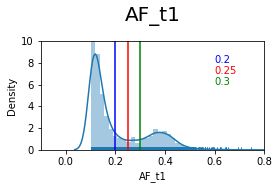

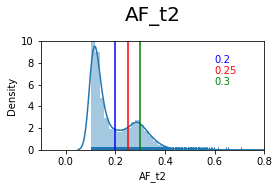

In [90]:
threshold = 0.1
for tissue in ['tumor1','tumor2']:
    suffix = suffixes_dict[tissue]
    col = 'AF'+suffix
    data = df[(df[col]>threshold)]
    y_var = col
    title = col
    xlim = 0.8
    bins = 50
    density_plot(data=data,y_var=y_var,title=title,xlim_min=-0.1,xlim_max=xlim,bins=bins)
    plt.ylim(0,10)
    plt.axvline(x = 0.2, color = 'b', label = '0.2')
    plt.axvline(x = 0.25, color = 'r', label = '0.25')
    plt.axvline(x = 0.3, color = 'g', label = '0.3')
    plt.text(x=0.6,y=8,s='0.2',color='b')
    plt.text(x=0.6,y=7,s='0.25',color='r')
    plt.text(x=0.6,y=6,s='0.3',color='g')

In [24]:
def sequencing_artifact (row,alt_reads_cols,qval_sa_cols,threshold,min_reads):
    
    reads_list = [True if reads >= min_reads else False for reads in row[alt_reads_cols] ]
    qvals_list = [True if qval > threshold else False for qval in row[qval_sa_cols] ]
    
    #if the mutations is present in all samples from the blood cohort, it is an artifact
    if row['present_at_all_bloods'] == True:
        return True
    else:
        #if the mutation is not present in the blood cohort
        if row['present_at_cohort'] == False:
            
            #if it is clonal in the tumors, it is not an artifact
            if (row['AF_t1'] > 0.25 or row['AF_t2'] > 0.2):
                return False
            
            #if it is present in at least 2 tissues, and in one of them has a minimum of n reads,
            #it is not an artifact
            elif row['n_tissues'] >= 2 and any(reads_list):
                return False
            else:
                return True
            
        else:
            
            #if it is present in the cohort, and in at least 1 sample the mutation follows a betabinomial
            #it is an artifact
            if any(qvals_list):
                return True
            else:
                return False

In [25]:
qval_sa_cols = ['qval_sa'+suffixes_dict[sample] for sample in suffixes_dict.keys()]

### Check different number of minimum reads

In [26]:
mut5_df['sequencing_artifact_min15'] = mut5_df.progress_apply(lambda row: sequencing_artifact(row,alt_reads_cols,qval_sa_cols,threshold=0.00001,min_reads=15),axis=1)

  0%|          | 0/651285 [00:00<?, ?it/s]

In [27]:
mut5_df['sequencing_artifact_min10'] = mut5_df.progress_apply(lambda row: sequencing_artifact(row,alt_reads_cols,qval_sa_cols,threshold=0.00001,min_reads=10),axis=1)
mut5_df['sequencing_artifact_min5'] = mut5_df.progress_apply(lambda row: sequencing_artifact(row,alt_reads_cols,qval_sa_cols,threshold=0.00001,min_reads=5),axis=1)
mut5_df['sequencing_artifact_min2'] = mut5_df.progress_apply(lambda row: sequencing_artifact(row,alt_reads_cols,qval_sa_cols,threshold=0.00001,min_reads=2),axis=1)

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

  0%|          | 0/651285 [00:00<?, ?it/s]

In [28]:
mut5_df.groupby(['sequencing_artifact_min15']).count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
sequencing_artifact_min15,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,2438,4,4,4,4,4,4,4,4,4,4,4,4,2438,2438,4,4,4,4,4,4,4,4,4,4,4,4,2438,2438,2438
True,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847,648847

In [29]:
mut5_df.groupby(['sequencing_artifact_min15','present_at_cohort']).count()

CHROM     POS     REF     ALT  \
sequencing_artifact_min15 present_at_cohort                                   
False                     False                2434    2434    2434    2434   
                          True                    4       4       4       4   
True                      False              179022  179022  179022  179022   
                          True               469825  469825  469825  469825   

                                             parents  mut_type  depth_t1  \
sequencing_artifact_min15 present_at_cohort                                
False                     False                 2434      2434      2434   
                          True                     4         4         4   
True                      False               179022    179022    179022   
                          True                469825    469825    469825   

                                             depth_t2  depth_b  depth_k  \
sequencing_artifact_min15 present_at_cohort                               
False                     False                  2434     2434     2434   
                          True                      4        4        4   
True                      False                179022   179022   179022   
                          True                 469825   469825   469825   

                                             depth_l  depth_p  depth_h  \
sequencing_artifact_min15 present_at_cohort                              
False                     False                 2434     2434     2434   
                          True                     4        4        4   
True                      False               179022   179022   179022   
                          True                469825   469825   469825   

                                             depth_lu  depth_me  depth_s  \
sequencing_artifact_min15 present_at_cohort                                
False                     False                  2434      2434     2434   
                          True                      4         4        4   
True                      False                179022    179022   179022   
                          True                 469825    469825   469825   

                                             depth_br  depth_bm  \
sequencing_artifact_min15 present_at_cohort                       
False                     False                  2434      2434   
                          True                      4         4   
True                      False                179022    179022   
                          True                 469825    469825   

                                             filter_depth_t1  filter_depth_t2  \
sequencing_artifact_min15 present_at_cohort                                     
False                     False                         2434             2434   
                          True                             4                4   
True                      False                       179022           179022   
                          True                        469825           469825   

                                             filter_depth_b  filter_depth_k  \
sequencing_artifact_min15 present_at_cohort                                   
False                     False                        2434            2434   
                          True                            4               4   
True                      False                      179022          179022   
                          True                       469825          469825   

                                             filter_depth_l  filter_depth_p  \
sequencing_artifact_min15 present_at_cohort                                   
False                     False                        2434            2434   
                          True                            4               4   
True                      False                      179022          179022   
 

In [30]:
mut5_df.groupby(['sequencing_artifact_min10']).count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min5,sequencing_artifact_min2
sequencing_artifact_min10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,3064,4,4,4,4,4,4,4,4,4,4,4,4,3064,3064,4,4,4,4,4,4,4,4,4,4,4,4,3064,3064,3064
True,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221,648221

In [31]:
mut5_df.groupby(['sequencing_artifact_min10','present_at_cohort']).count()

CHROM     POS     REF     ALT  \
sequencing_artifact_min10 present_at_cohort                                   
False                     False                3060    3060    3060    3060   
                          True                    4       4       4       4   
True                      False              178396  178396  178396  178396   
                          True               469825  469825  469825  469825   

                                             parents  mut_type  depth_t1  \
sequencing_artifact_min10 present_at_cohort                                
False                     False                 3060      3060      3060   
                          True                     4         4         4   
True                      False               178396    178396    178396   
                          True                469825    469825    469825   

                                             depth_t2  depth_b  depth_k  \
sequencing_artifact_min10 present_at_cohort                               
False                     False                  3060     3060     3060   
                          True                      4        4        4   
True                      False                178396   178396   178396   
                          True                 469825   469825   469825   

                                             depth_l  depth_p  depth_h  \
sequencing_artifact_min10 present_at_cohort                              
False                     False                 3060     3060     3060   
                          True                     4        4        4   
True                      False               178396   178396   178396   
                          True                469825   469825   469825   

                                             depth_lu  depth_me  depth_s  \
sequencing_artifact_min10 present_at_cohort                                
False                     False                  3060      3060     3060   
                          True                      4         4        4   
True                      False                178396    178396   178396   
                          True                 469825    469825   469825   

                                             depth_br  depth_bm  \
sequencing_artifact_min10 present_at_cohort                       
False                     False                  3060      3060   
                          True                      4         4   
True                      False                178396    178396   
                          True                 469825    469825   

                                             filter_depth_t1  filter_depth_t2  \
sequencing_artifact_min10 present_at_cohort                                     
False                     False                         3060             3060   
                          True                             4                4   
True                      False                       178396           178396   
                          True                        469825           469825   

                                             filter_depth_b  filter_depth_k  \
sequencing_artifact_min10 present_at_cohort                                   
False                     False                        3060            3060   
                          True                            4               4   
True                      False                      178396          178396   
                          True                       469825          469825   

                                             filter_depth_l  filter_depth_p  \
sequencing_artifact_min10 present_at_cohort                                   
False                     False                        3060            3060   
                          True                            4               4   
True                      False                      178396          178396   
 

In [32]:
mut5_df.groupby(['sequencing_artifact_min5']).count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min2
sequencing_artifact_min5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,11529,4,4,4,4,4,4,4,4,4,4,4,4,11529,11529,4,4,4,4,4,4,4,4,4,4,4,4,11529,11529,11529
True,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,639756,63

In [33]:
mut5_df.groupby(['sequencing_artifact_min5','present_at_cohort']).count()

CHROM     POS     REF     ALT  \
sequencing_artifact_min5 present_at_cohort                                   
False                    False               11525   11525   11525   11525   
                         True                    4       4       4       4   
True                     False              169931  169931  169931  169931   
                         True               469825  469825  469825  469825   

                                            parents  mut_type  depth_t1  \
sequencing_artifact_min5 present_at_cohort                                
False                    False                11525     11525     11525   
                         True                     4         4         4   
True                     False               169931    169931    169931   
                         True                469825    469825    469825   

                                            depth_t2  depth_b  depth_k  \
sequencing_artifact_min5 present_at_cohort                               
False                    False                 11525    11525    11525   
                         True                      4        4        4   
True                     False                169931   169931   169931   
                         True                 469825   469825   469825   

                                            depth_l  depth_p  depth_h  \
sequencing_artifact_min5 present_at_cohort                              
False                    False                11525    11525    11525   
                         True                     4        4        4   
True                     False               169931   169931   169931   
                         True                469825   469825   469825   

                                            depth_lu  depth_me  depth_s  \
sequencing_artifact_min5 present_at_cohort                                
False                    False                 11525     11525    11525   
                         True                      4         4        4   
True                     False                169931    169931   169931   
                         True                 469825    469825   469825   

                                            depth_br  depth_bm  \
sequencing_artifact_min5 present_at_cohort                       
False                    False                 11525     11525   
                         True                      4         4   
True                     False                169931    169931   
                         True                 469825    469825   

                                            filter_depth_t1  filter_depth_t2  \
sequencing_artifact_min5 present_at_cohort                                     
False                    False                        11525            11525   
                         True                             4                4   
True                     False                       169931           169931   
                         True                        469825           469825   

                                            filter_depth_b  filter_depth_k  \
sequencing_artifact_min5 present_at_cohort                                   
False                    False                       11525           11525   
                         True                            4               4   
True                     False                      169931          169931   
                         True                       469825          469825   

                                            filter_depth_l  filter_depth_p  \
sequencing_artifact_min5 present_at_cohort                                   
False                    False                       11525           11525   
                         True                            4               4   
True                     False                      169931          169931   
                         True                       4

In [34]:
mut5_df.groupby(['sequencing_artifact_min2']).count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5
sequencing_artifact_min2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,56575,4,4,4,4,4,4,4,4,4,4,4,4,56575,56575,4,4,4,4,4,4,4,4,4,4,4,4,56575,56575,56575
True,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,594710,59

In [35]:
mut5_df.groupby(['sequencing_artifact_min2','present_at_cohort']).count()

CHROM     POS     REF     ALT  \
sequencing_artifact_min2 present_at_cohort                                   
False                    False               56571   56571   56571   56571   
                         True                    4       4       4       4   
True                     False              124885  124885  124885  124885   
                         True               469825  469825  469825  469825   

                                            parents  mut_type  depth_t1  \
sequencing_artifact_min2 present_at_cohort                                
False                    False                56571     56571     56571   
                         True                     4         4         4   
True                     False               124885    124885    124885   
                         True                469825    469825    469825   

                                            depth_t2  depth_b  depth_k  \
sequencing_artifact_min2 present_at_cohort                               
False                    False                 56571    56571    56571   
                         True                      4        4        4   
True                     False                124885   124885   124885   
                         True                 469825   469825   469825   

                                            depth_l  depth_p  depth_h  \
sequencing_artifact_min2 present_at_cohort                              
False                    False                56571    56571    56571   
                         True                     4        4        4   
True                     False               124885   124885   124885   
                         True                469825   469825   469825   

                                            depth_lu  depth_me  depth_s  \
sequencing_artifact_min2 present_at_cohort                                
False                    False                 56571     56571    56571   
                         True                      4         4        4   
True                     False                124885    124885   124885   
                         True                 469825    469825   469825   

                                            depth_br  depth_bm  \
sequencing_artifact_min2 present_at_cohort                       
False                    False                 56571     56571   
                         True                      4         4   
True                     False                124885    124885   
                         True                 469825    469825   

                                            filter_depth_t1  filter_depth_t2  \
sequencing_artifact_min2 present_at_cohort                                     
False                    False                        56571            56571   
                         True                             4                4   
True                     False                       124885           124885   
                         True                        469825           469825   

                                            filter_depth_b  filter_depth_k  \
sequencing_artifact_min2 present_at_cohort                                   
False                    False                       56571           56571   
                         True                            4               4   
True                     False                      124885          124885   
                         True                       469825          469825   

                                            filter_depth_l  filter_depth_p  \
sequencing_artifact_min2 present_at_cohort                                   
False                    False                       56571           56571   
                         True                            4               4   
True                     False                      124885          124885   
                         True                       4

In [36]:
suffixes_dict

{'tumor1': '_t1',
 'tumor2': '_t2',
 'blood': '_b',
 'kidney': '_k',
 'liver': '_l',
 'pancreas': '_p',
 'heart': '_h',
 'lung': '_lu',
 'medulla': '_me',
 'spleen': '_s',
 'brain': '_br',
 'bma': '_bm'}

## Check in heatmap plots the different filters

In [37]:
tissues = suffixes_dict.keys()
af_cols = ['AF'+suffixes_dict[sample] for sample in suffixes_dict.keys()]

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
df15 = mut5_df[mut5_df['sequencing_artifact_min15']==False]
df10 = mut5_df[mut5_df['sequencing_artifact_min10']==False]
df5 = mut5_df[mut5_df['sequencing_artifact_min5']==False]
df2 = mut5_df[mut5_df['sequencing_artifact_min2']==False]

In [40]:
df2.groupby('present_at_cohort').count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
present_at_cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,56571,0,0,0,0,0,0,0,0,0,0,0,0,56571,0,0,0,0,0,0,0,0,0,0,0,0,56571,56571,56571,56571
True,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [41]:
df5.groupby('present_at_cohort').count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
present_at_cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,11525,0,0,0,0,0,0,0,0,0,0,0,0,11525,0,0,0,0,0,0,0,0,0,0,0,0,11525,11525,11525,11525
True,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [42]:
df10.groupby('present_at_cohort').count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
present_at_cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,3060,0,0,0,0,0,0,0,0,0,0,0,0,3060,0,0,0,0,0,0,0,0,0,0,0,0,3060,3060,3060,3060
True,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [43]:
df10[df10['present_at_cohort']==True]

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
16969,chr11,26161735,C,A,False,snv,106.0,136.0,147.0,139.0,115.0,107.0,129.0,121.0,66.0,152.0,104.0,159.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.4623,57,49,106,0.5662,59,77,136,0.4762,77,70,147,0.5468,63,76,139,0.5391,53,62,115,0.4953,54,53,107,0.5349,59,69,129,0.5207,58,63,121,0.5303,31,35,66,0.4408,85,67,152,0.5288,49,55,104,0.4654,85,74,159,0.0,47,0,47,0.0,23,0,23,True,True,True,True,True,True,True,True,True,True,True,True,False,False,12,11,26161735,26161735,C/A,+,11_26161735_C/A,11:26161735,A,-,-,-,intergenic_variant,-,-,-,-,-,-,MODIFIER,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,chr11:26161735-26161735,0.000007,-,C/A,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,5.079317e-07,1.962365e-09,1.416185e-07,5.134086e-09,1.237156e-08,1.168915e-07,1.130068e-08,2.658832e-08,1.067373e-07,6.537885e-07,2.683023e-08,2.021604e-07,True,False,1.121754e-06,3.900892e-09,2.562579e-07,6.966954e-09,2.365230e-08,1.557276e-07,2.170842e-08,3.460901e-08,1.572988e-07,7.326235e-07,3.429819e-08,3.914328e-07,False,False,False,False
77232,chr3,164290636,C,A,False,snv,104.0,121.0,140.0,113.0,85.0,116.0,111.0,120.0,79.0,160.0,84.0,133.0,True,True,True,True,True,True,True,True,True,True,True,True,True,0.5000,52,52,104,0.4050,72,49,121,0.4929,71,69,140,0.4513,62,51,113,0.4471,47,38,85,0.4655,62,54,116,0.5225,53,58,111,0.4500,66,54,120,0.4937,40,39,79,0.5188,77,83,160,0.5357,39,45,84,0.4737,70,63,133,0.0,30,0,30,0.0,33,0,33,True,True,True,True,True,True,True,True,True,True,True,True,False,False,12,3,164290636,164290636,C/A,+,3_164290636_C/A,3:164290636,A,-,-,-,intergenic_variant,-,-,-,-,-,rs557371630,MODIFIER,-,-,-,-,-,-,-,-,-,0.0303,0.0043,0,0,0,-,-,-,rs557371630,0.008264,-,C/A,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1.023499e-07,4.240160e-06,7.224499e-08,7.116644e-07,1.578337e-06,3.666827e-07,3.054512e-08,6.689205e-07,2.837307e-07,1.565471e-08,3.735295e-08,1.935189e-07,True,False,2.260370e-07,8.428814e-06,1.307269e-0

In [44]:
df15.groupby('present_at_cohort').count()

,CHROM,POS,REF,ALT,parents,mut_type,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
present_at_cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,2434,0,0,0,0,0,0,0,0,0,0,0,0,2434,0,0,0,0,0,0,0,0,0,0,0,0,2434,2434,2434,2434
True,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [45]:
grp10_df = df10[['n_tissues','CHROM']].groupby('n_tissues').count()
grp10_df = grp10_df.rename(columns={'CHROM':'10reads'})
grp15_df = df15[['n_tissues','CHROM']].groupby('n_tissues').count()
grp15_df = grp15_df.rename(columns={'CHROM':'15reads'})
grp5_df = df5[['n_tissues','CHROM']].groupby('n_tissues').count()
grp5_df = grp5_df.rename(columns={'CHROM':'5reads'})
grp2_df = df2[['n_tissues','CHROM']].groupby('n_tissues').count()
grp2_df = grp2_df.rename(columns={'CHROM':'2reads'})
grp_df = pd.merge(grp2_df,grp5_df,how='outer',left_index=True,right_index=True)
grp_df = pd.merge(grp_df,grp10_df,how='outer',left_index=True,right_index=True)
grp_df = pd.merge(grp_df,grp15_df,how='outer',left_index=True,right_index=True)
grp_df

,2reads,5reads,10reads,15reads
n_tissues,,,,
1,621,621,621,621
2,17679,1212,482,433
3,14083,1748,584,539
4,9564,1949,465,441
5,5942,1648,214,166
6,3552,1352,111,57
7,2047,945,77,14
8,1162,627,59,1
9,723,430,54,5


Text(0.5, 1.0, 'Number of mutations present in n tissues')

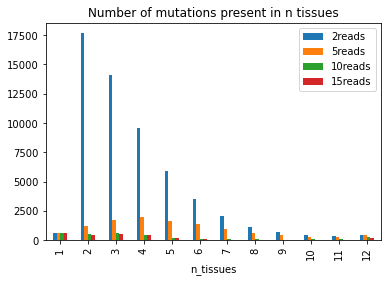

In [48]:
grp_df.plot.bar()
plt.title('Number of mutations present in n tissues')

In [49]:
print(len(df10[df10['tumor1']==True]),'muts at tumor1')
print(len(df10[df10['tumor2']==True]),'muts at tumor2')

1438 muts at tumor1
1988 muts at tumor2


In [50]:
print(len(df5[df5['tumor1']==True]),'muts at tumor1')
print(len(df5[df5['tumor2']==True]),'muts at tumor2')

3881 muts at tumor1
4714 muts at tumor2


In [51]:
print(len(df2[df2['tumor1']==True]),'muts at tumor1')
print(len(df2[df2['tumor2']==True]),'muts at tumor2')

10777 muts at tumor1
13040 muts at tumor2


In [52]:
print(len(df15[df15['AF_t1']>0.25]),'clonal muts at tumor1')
print(len(df15[df15['AF_t2']>0.2]),'clonal muts at tumor2')

948 clonal muts at tumor1
1414 clonal muts at tumor2


In [53]:
print(len(df10[df10['AF_t1']>0.25]),'clonal muts at tumor1')
print(len(df10[df10['AF_t2']>0.2]),'clonal muts at tumor2')

948 clonal muts at tumor1
1414 clonal muts at tumor2


In [54]:
print(len(df5[df5['AF_t1']>0.25]),'clonal muts at tumor1')
print(len(df5[df5['AF_t2']>0.2]),'clonal muts at tumor2')

948 clonal muts at tumor1
1414 clonal muts at tumor2


In [55]:
print(len(df2[df2['AF_t1']>0.25]),'clonal muts at tumor1')
print(len(df2[df2['AF_t2']>0.2]),'clonal muts at tumor2')

948 clonal muts at tumor1
1414 clonal muts at tumor2


In [56]:
tissues

dict_keys(['tumor1', 'tumor2', 'blood', 'kidney', 'liver', 'pancreas', 'heart', 'lung', 'medulla', 'spleen', 'brain', 'bma'])

### Check threshold of 15 mutations

1


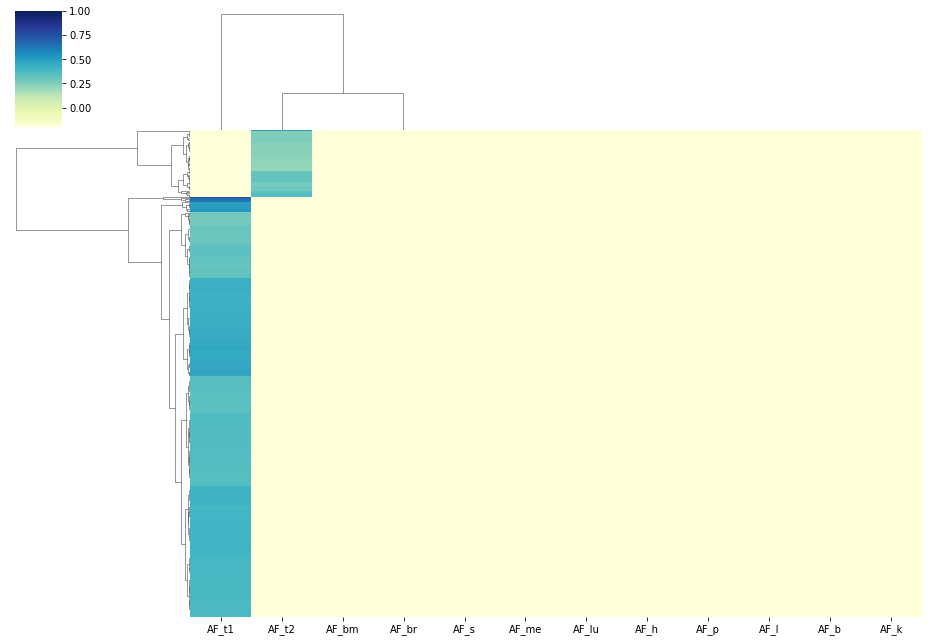

2


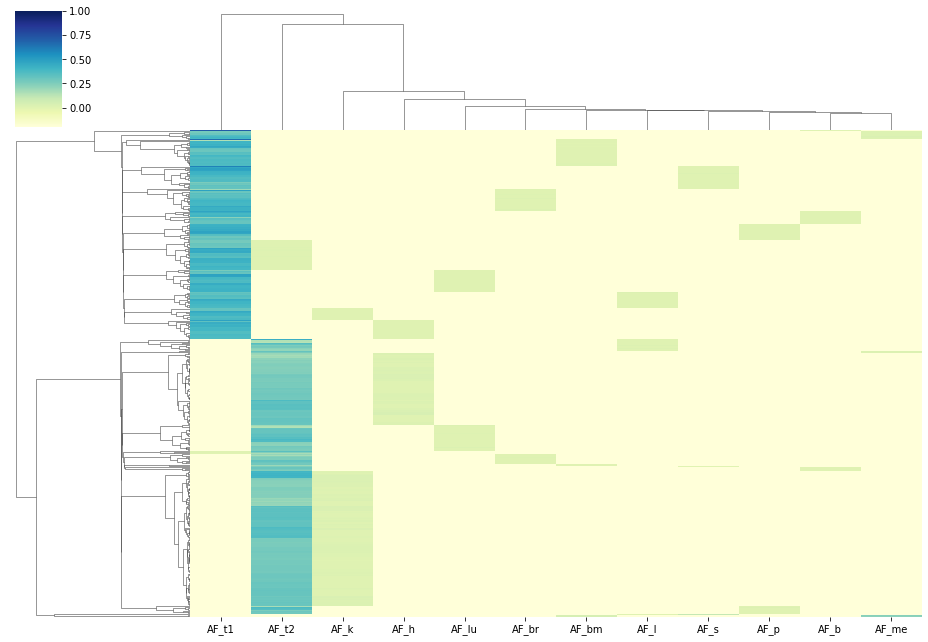

3


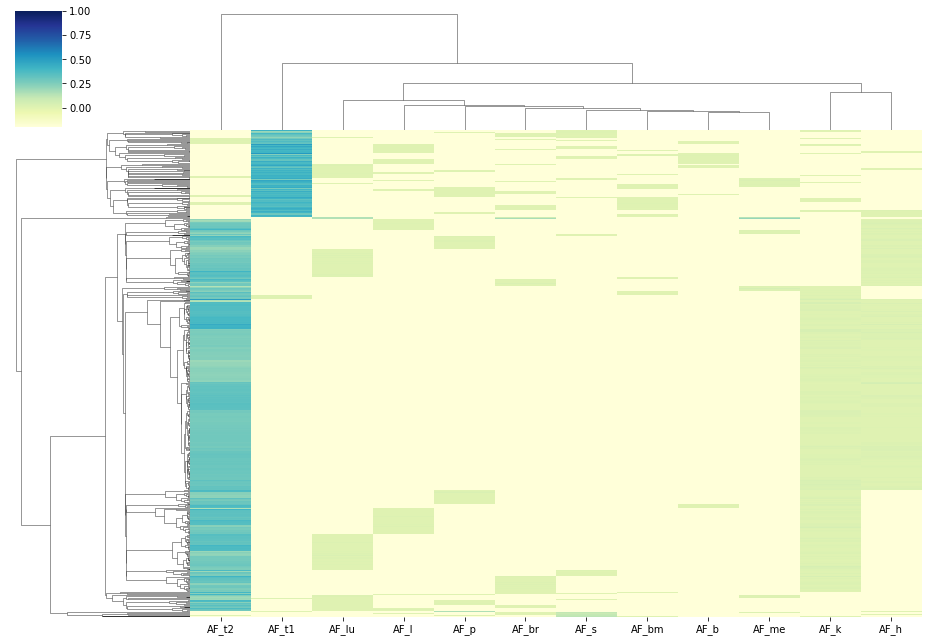

4


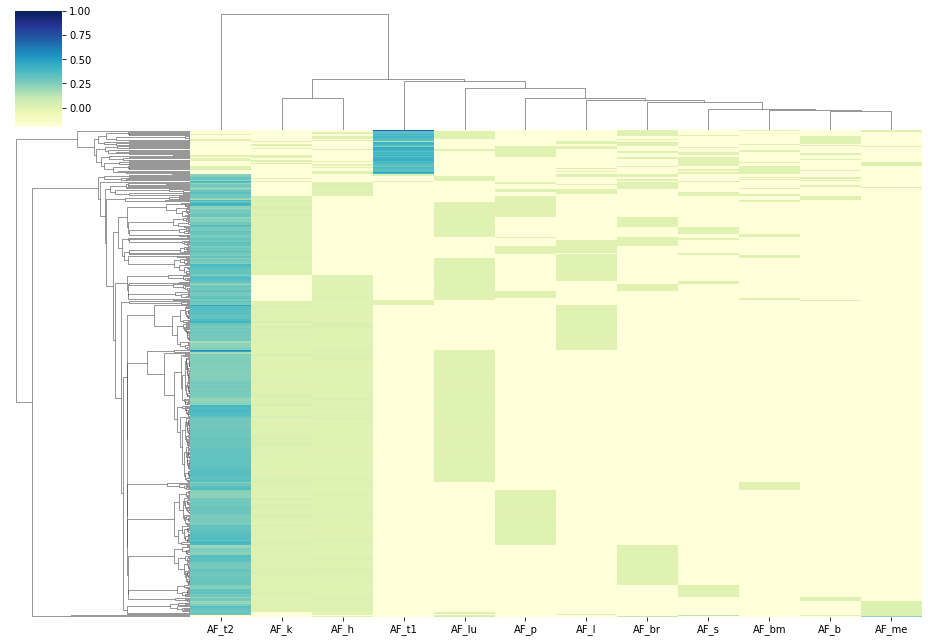

5


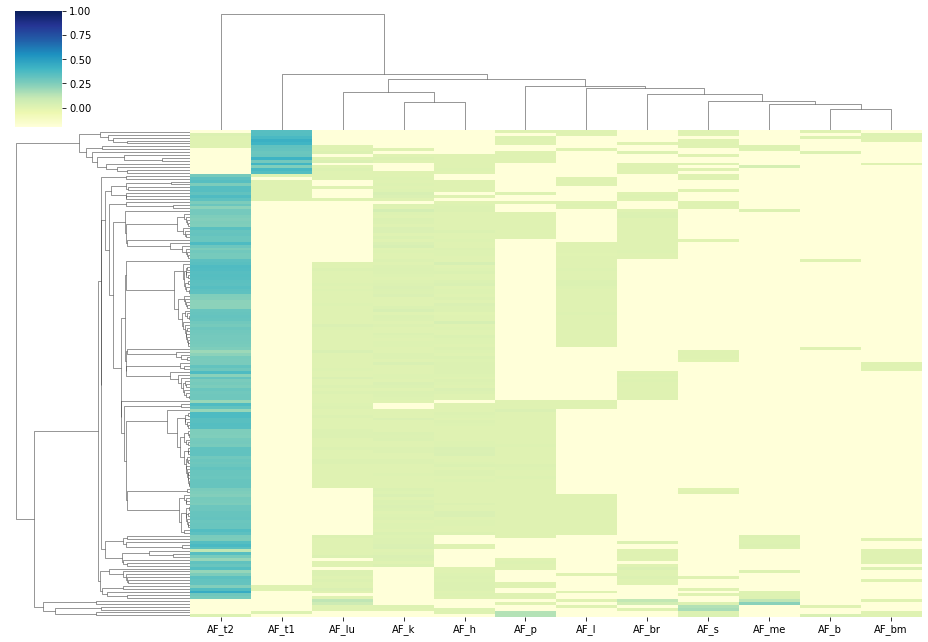

6


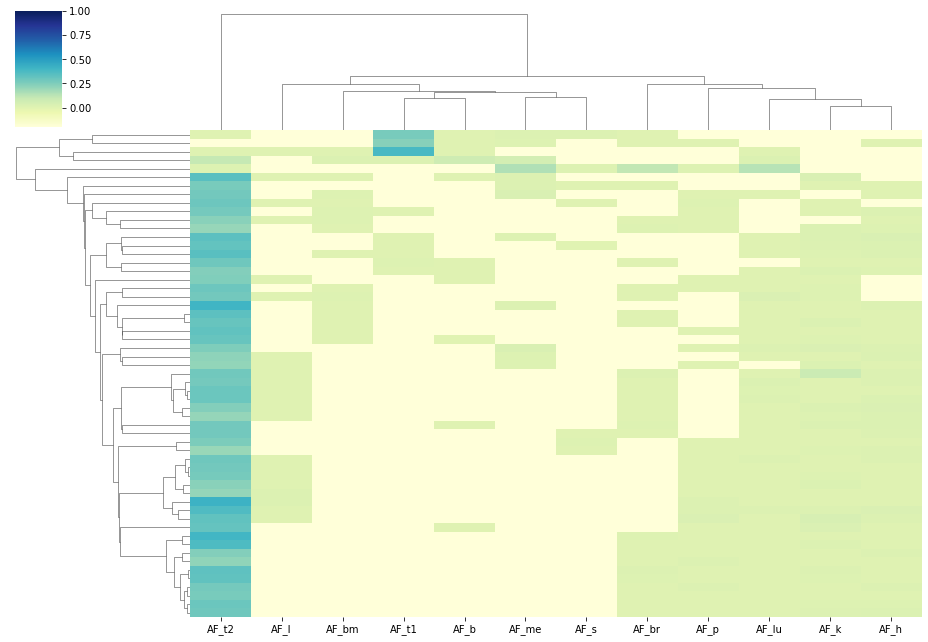

7


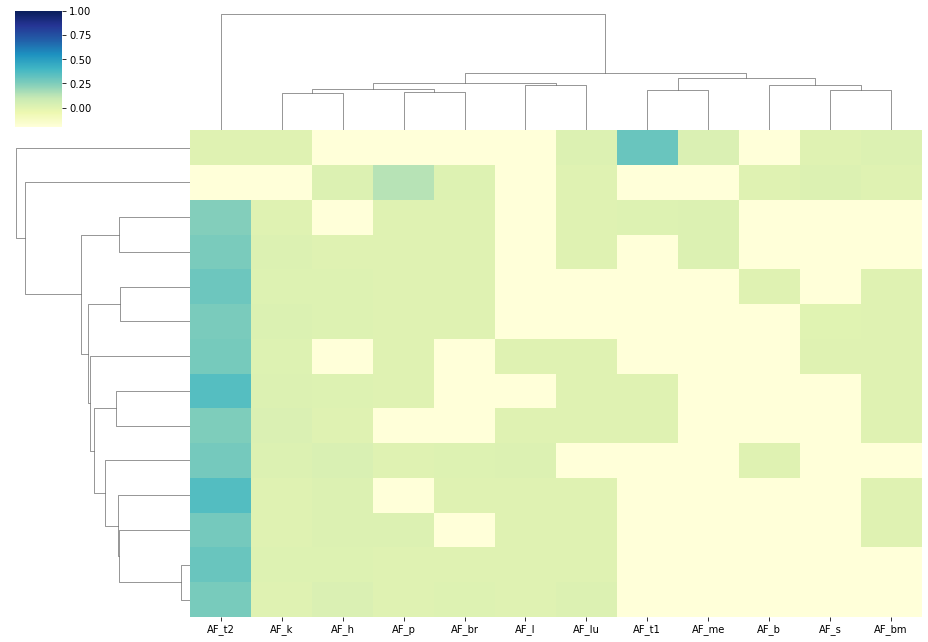

8
9


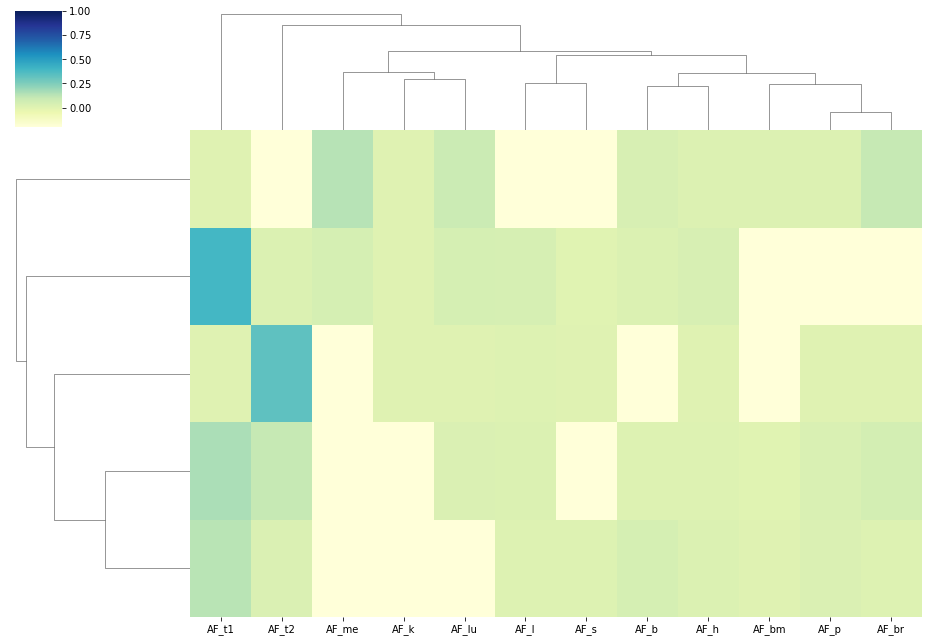

10


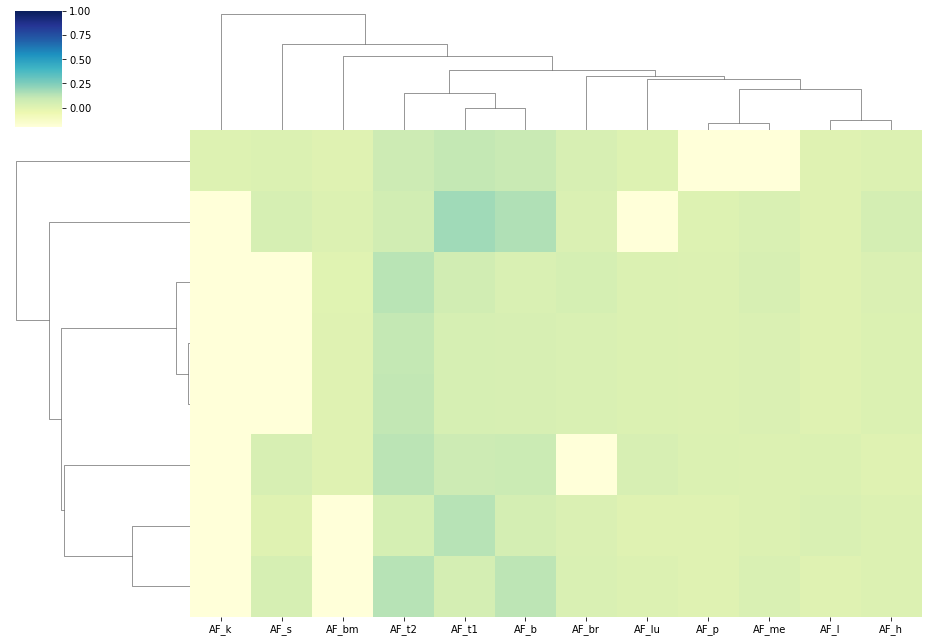

11


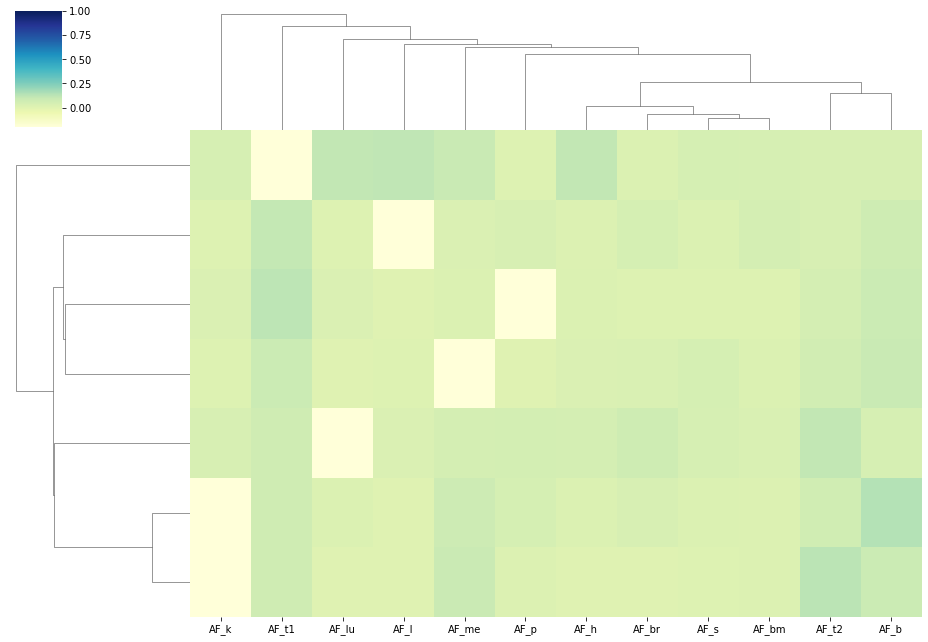

12


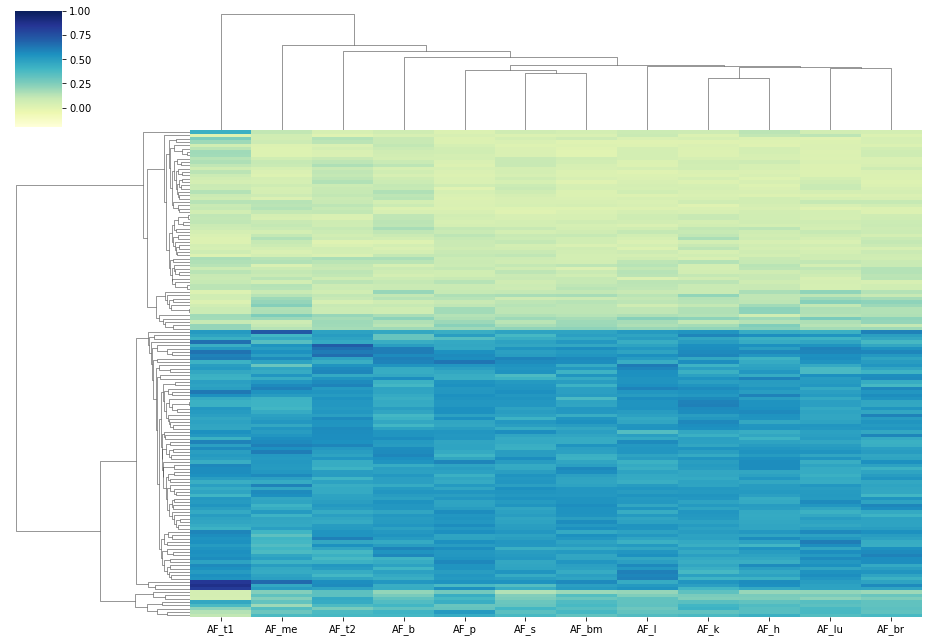

In [133]:
#check mutations with a minimum of shared tissues
for n in range(1,13):
    data = df15[df15['n_tissues']==n].sort_values(by=af_cols,ascending=False)
    print(n)
    if len(data) <= 1:
        pass
    else:
        data[af_cols] = data[af_cols].replace(0,-0.2)
        yticklabels = False
        sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
        plt.show()

/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


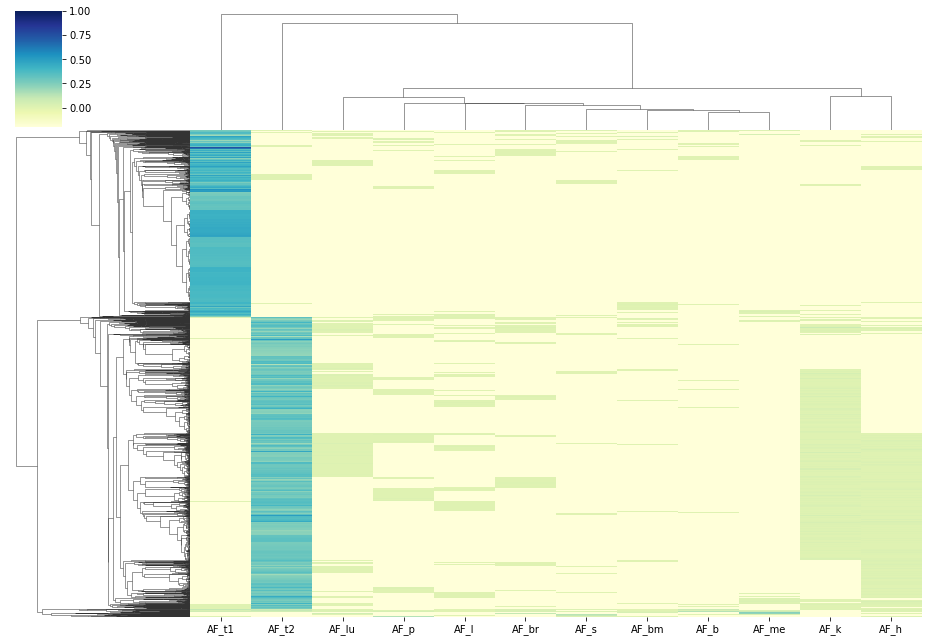

In [114]:
#Check mutations that are not present in all tissues
data = df15[df15['n_tissues']!=12].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

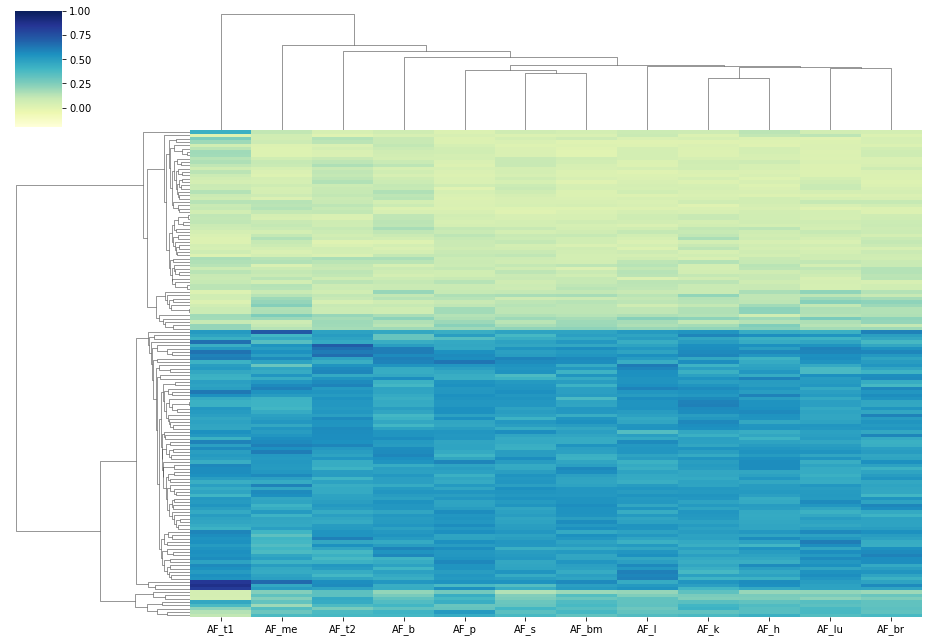

In [116]:
#check mutations that are present in all tissues
data = df15[df15['n_tissues']==12].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

Present in all 10 tissues


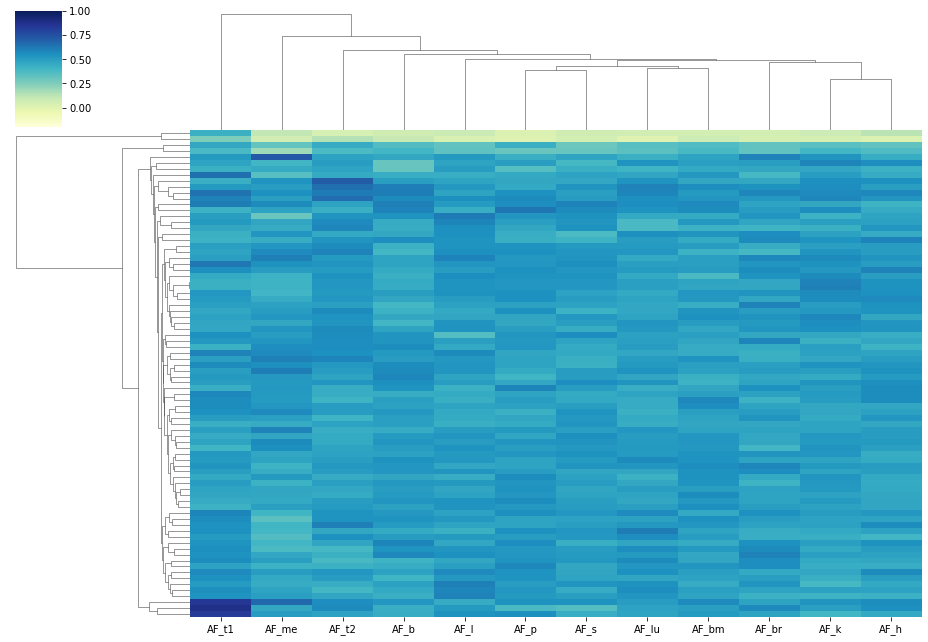

In [126]:
#Clonal in Tumor1
n=10
print('Present in all',n, 'tissues')
data = df15[(df15['n_tissues']>=n)&(df15['AF_t1']>0.25)].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

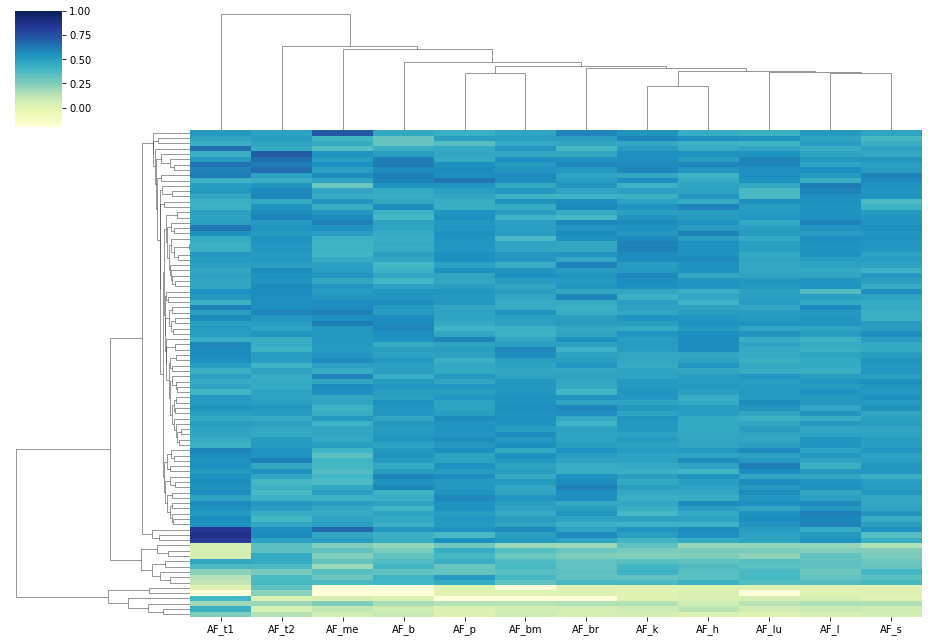

In [117]:
data = df15[(df15['n_tissues']>=8)&((df15['AF_t1']>0.25)|(df15['AF_t2']>0.2))].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

### Check threshold of 10 mutations

Present in all 1 tissues


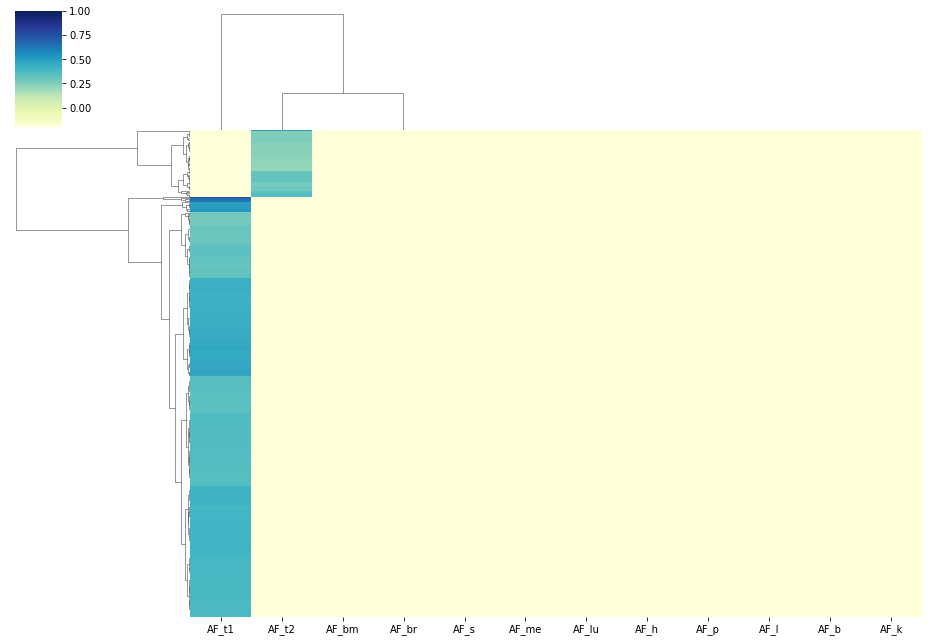

Present in all 2 tissues


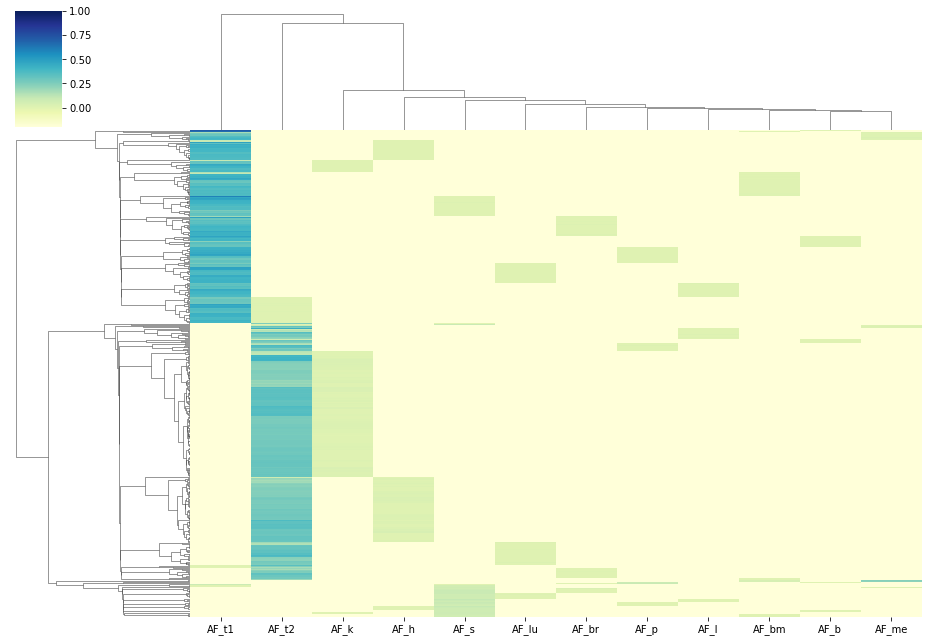

Present in all 3 tissues


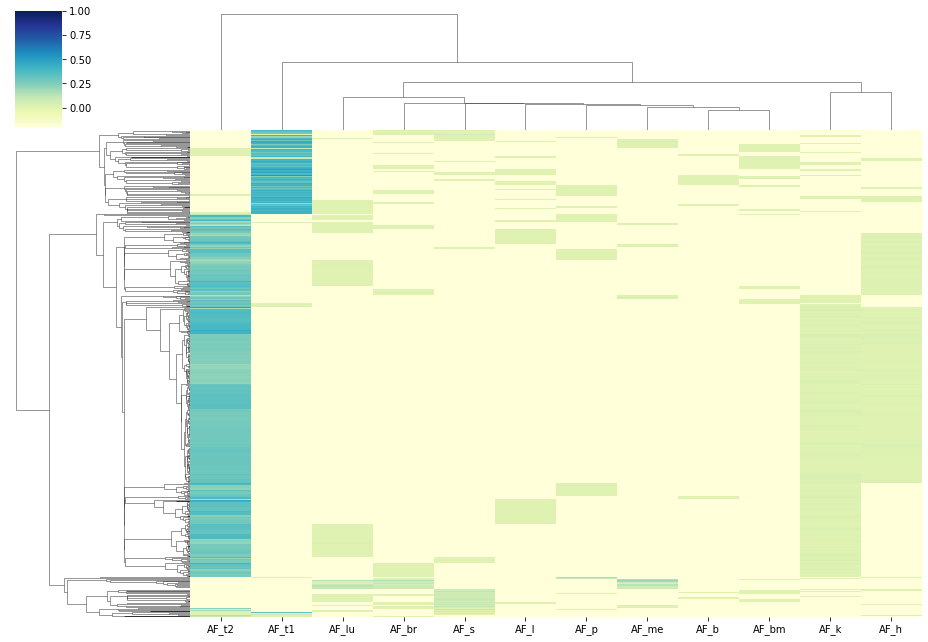

Present in all 4 tissues


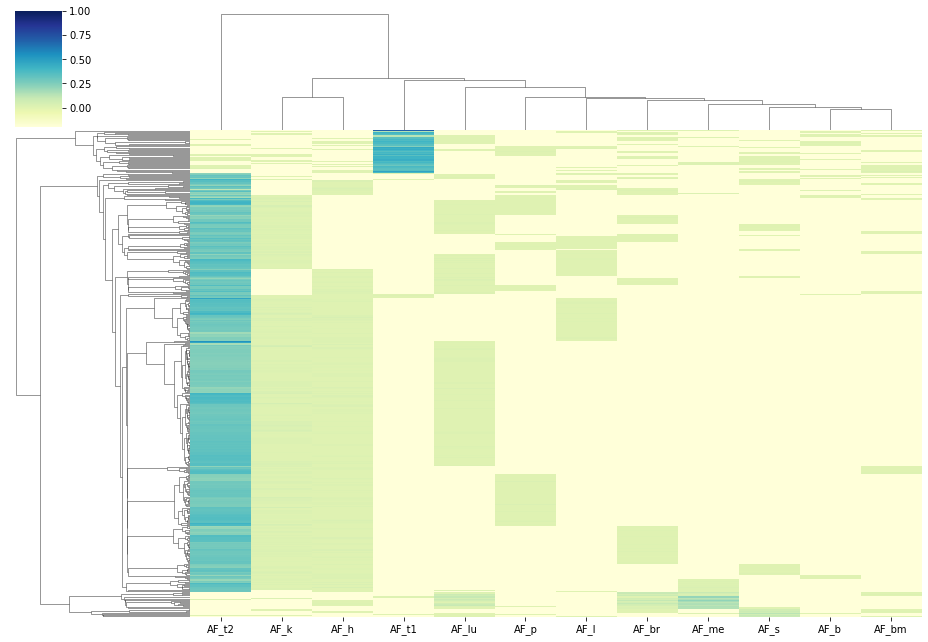

Present in all 5 tissues


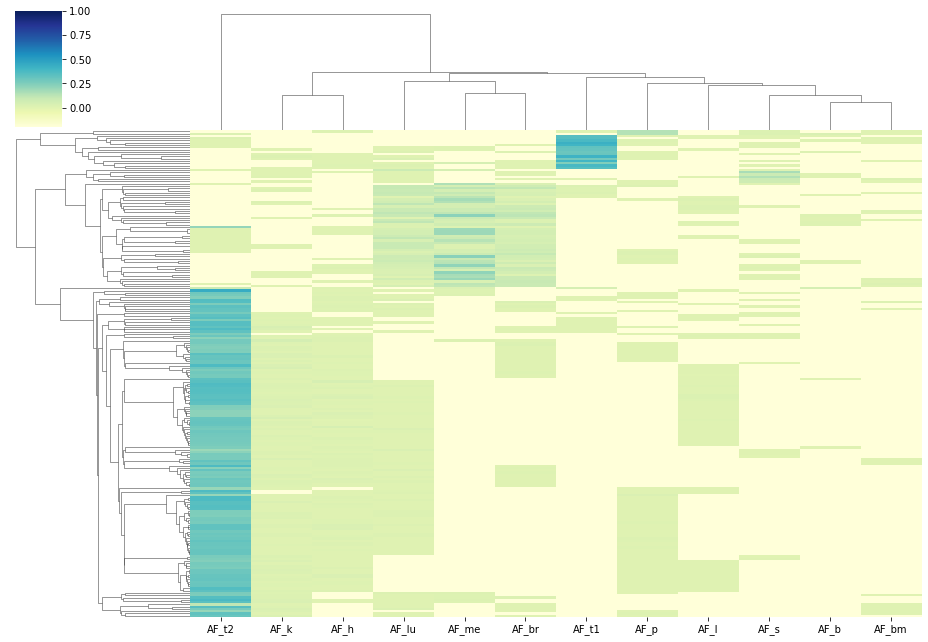

Present in all 6 tissues


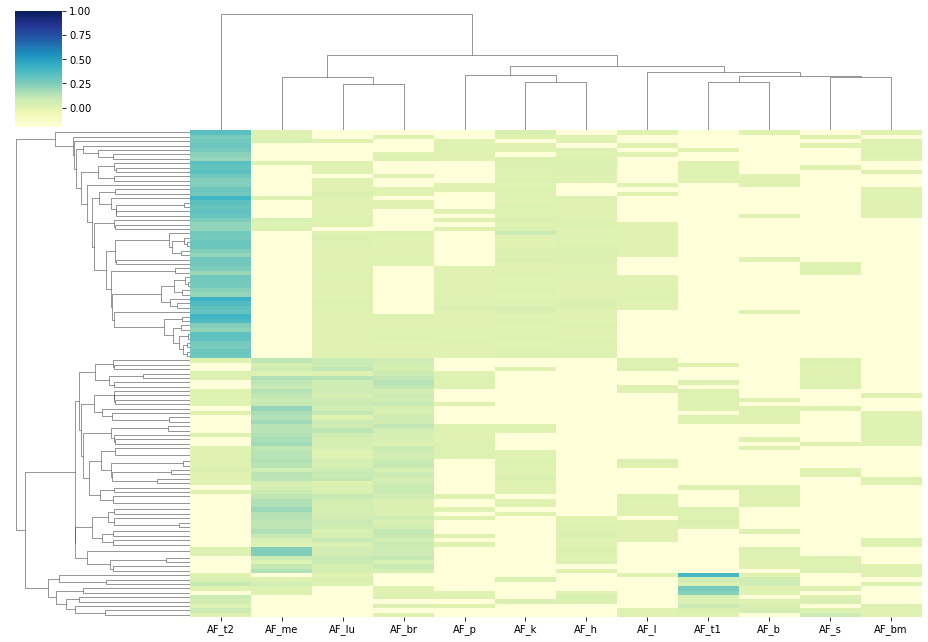

Present in all 7 tissues


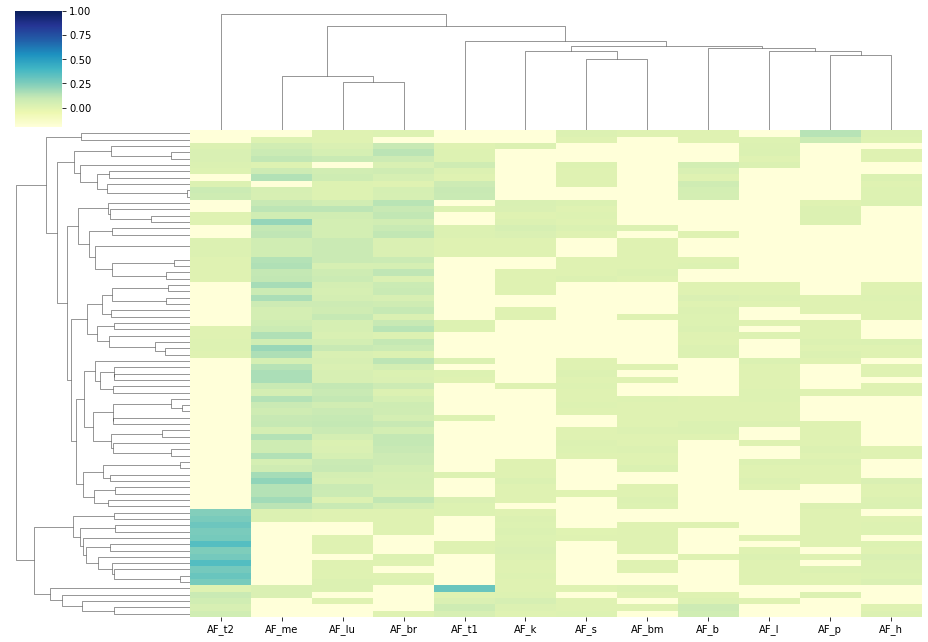

Present in all 8 tissues


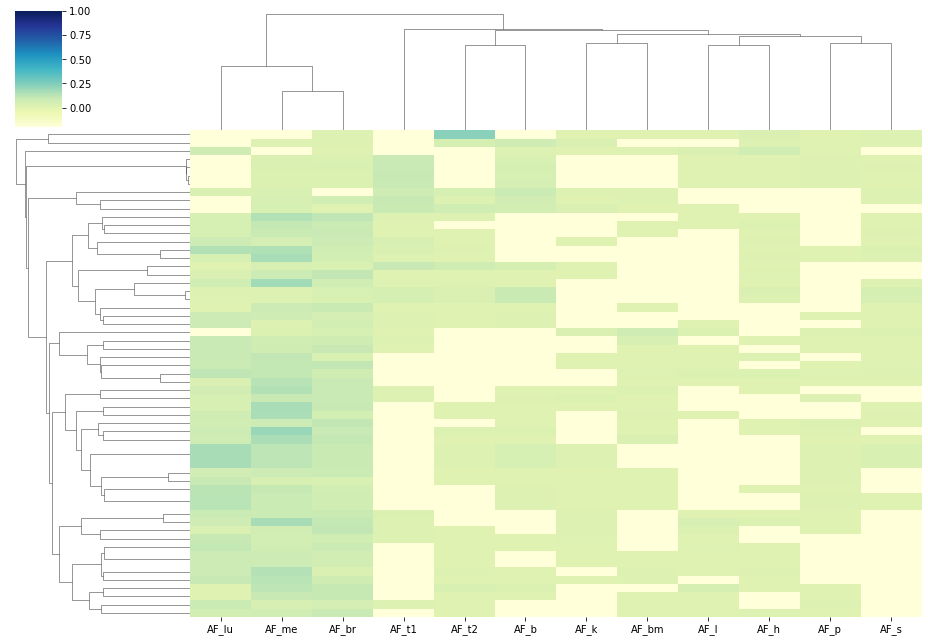

Present in all 9 tissues


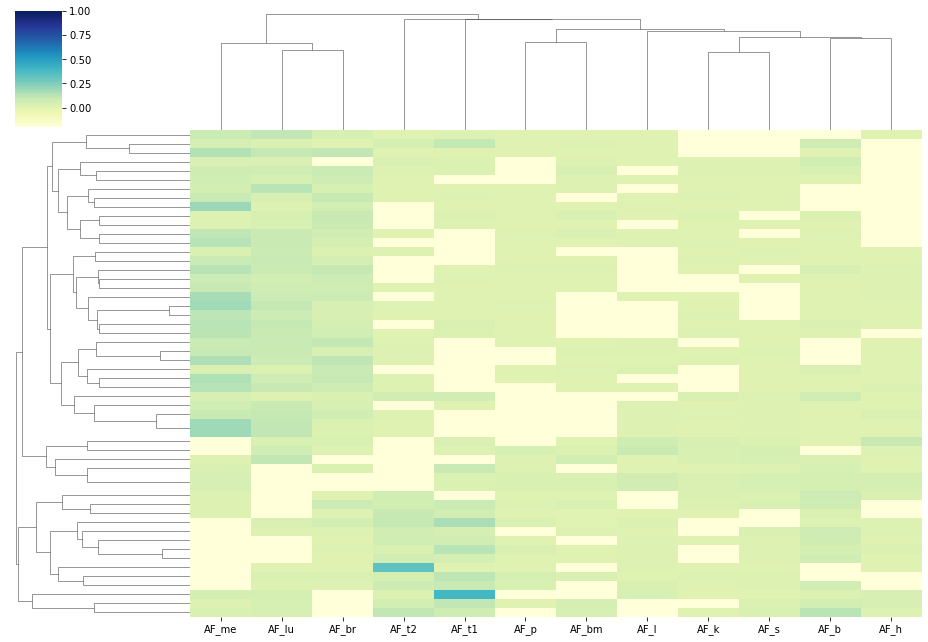

In [91]:
for n in range(1,10):
    print('Present in all',n, 'tissues')
    data = df10[df10['n_tissues']==n].sort_values(by=af_cols,ascending=False)
    data[af_cols] = data[af_cols].replace(0,-0.2)
    if len(data) < 50:
        height = 5
        yticklabels = True
    else:
        height = 9
        yticklabels = False
    sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
    plt.show()

/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


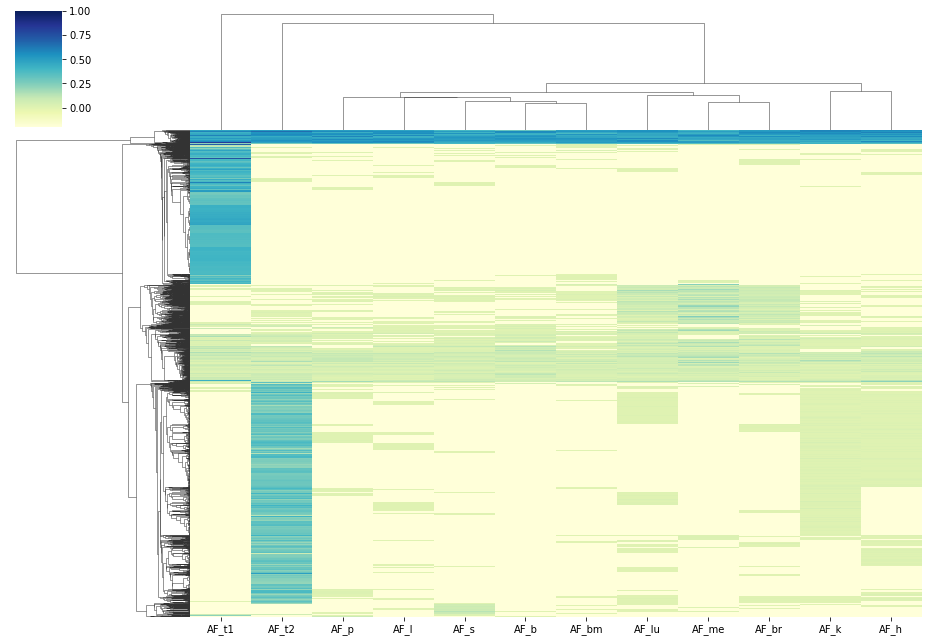

In [120]:
data = df10.sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

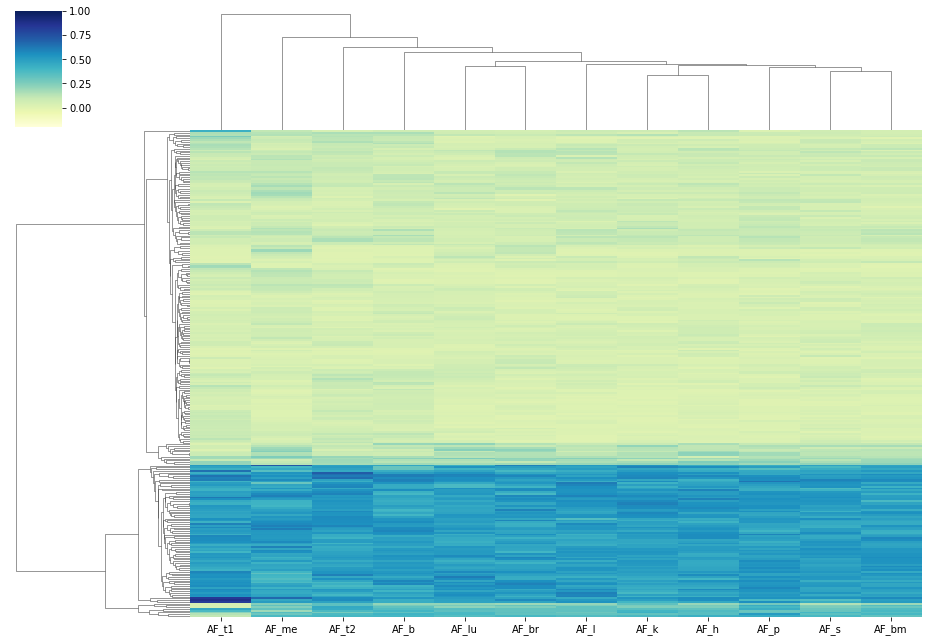

In [121]:
data = df10[df10['n_tissues']==12].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

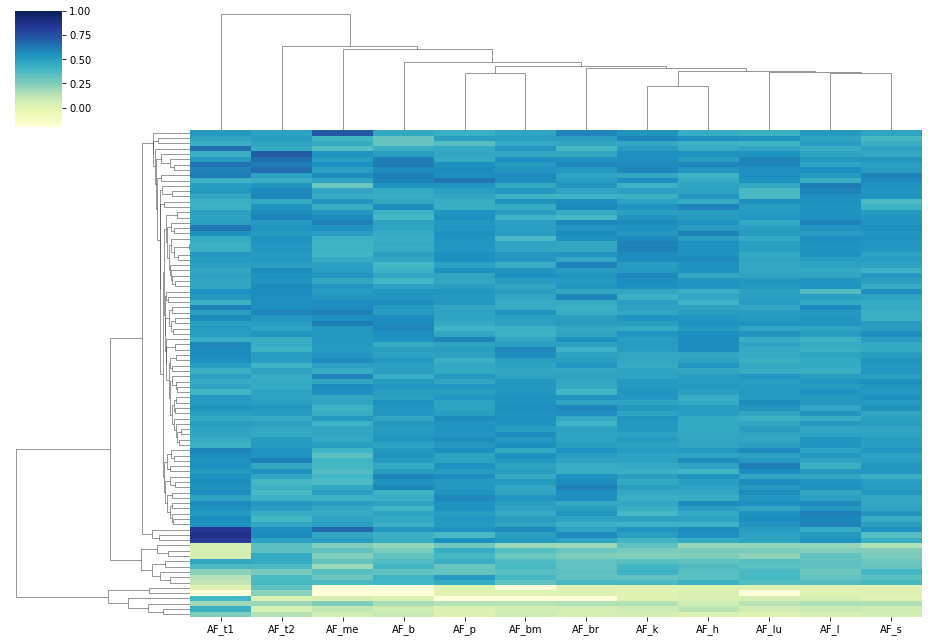

In [118]:
data = df10[(df10['n_tissues']>=8)&((df15['AF_t1']>0.25)|(df15['AF_t2']>0.2))].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

### Check threshold of 5 mutations

Present in all 1 tissues


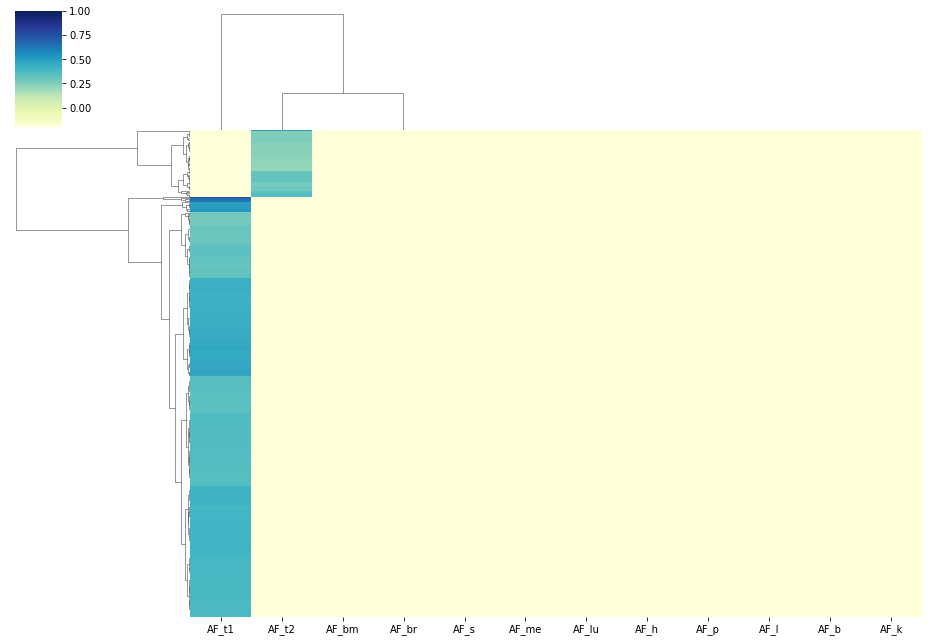

Present in all 2 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


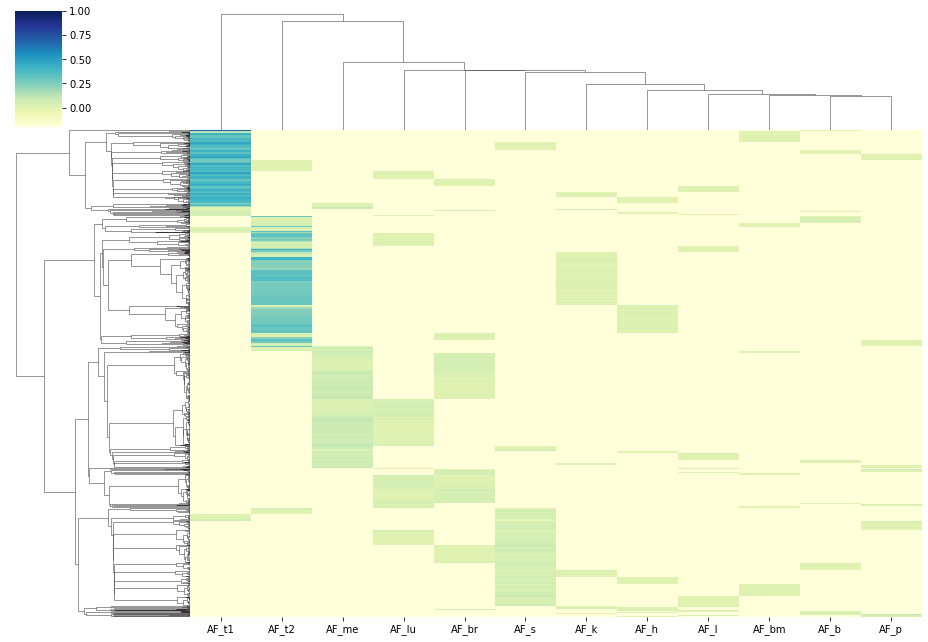

Present in all 3 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


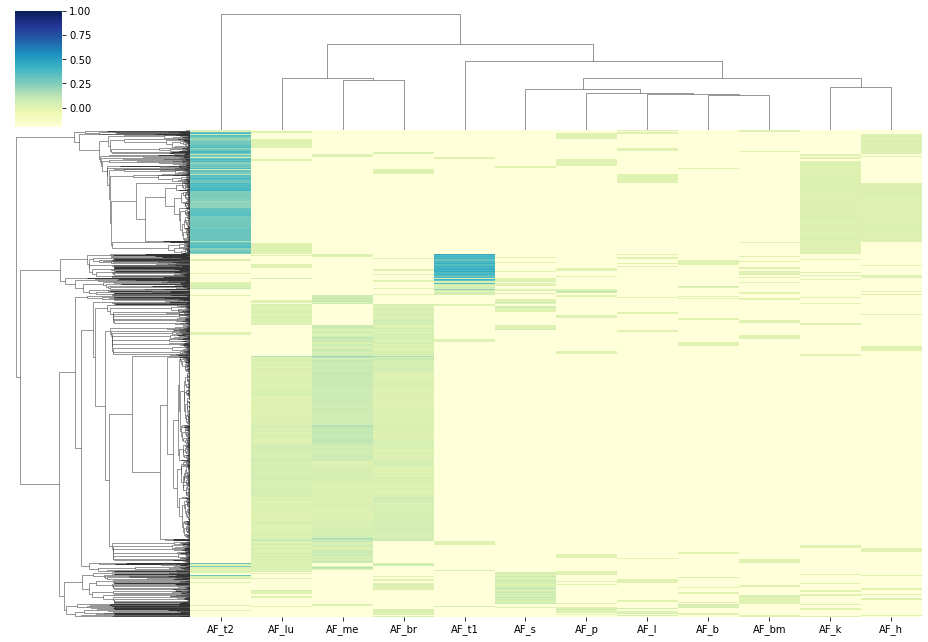

Present in all 4 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


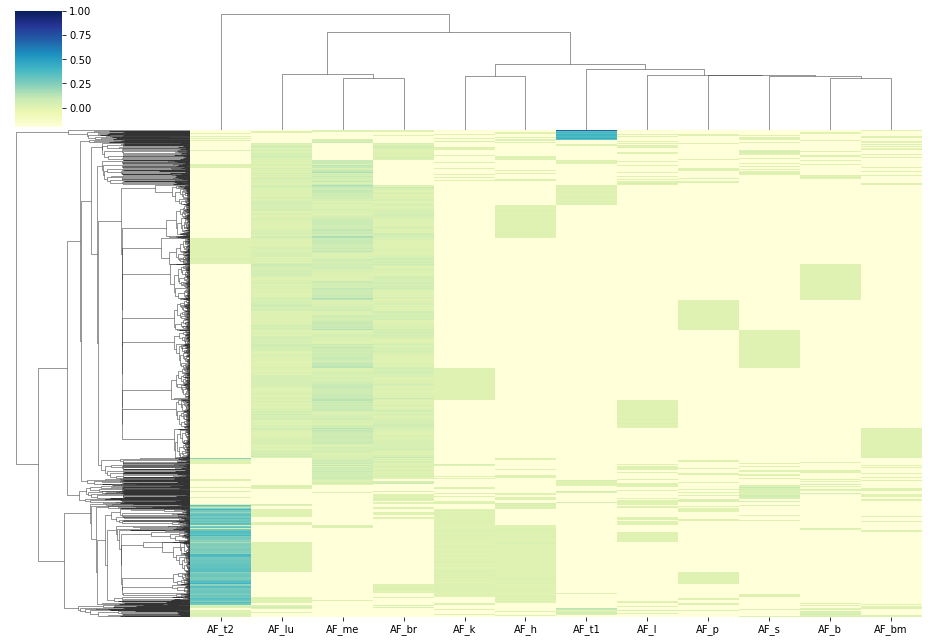

Present in all 5 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


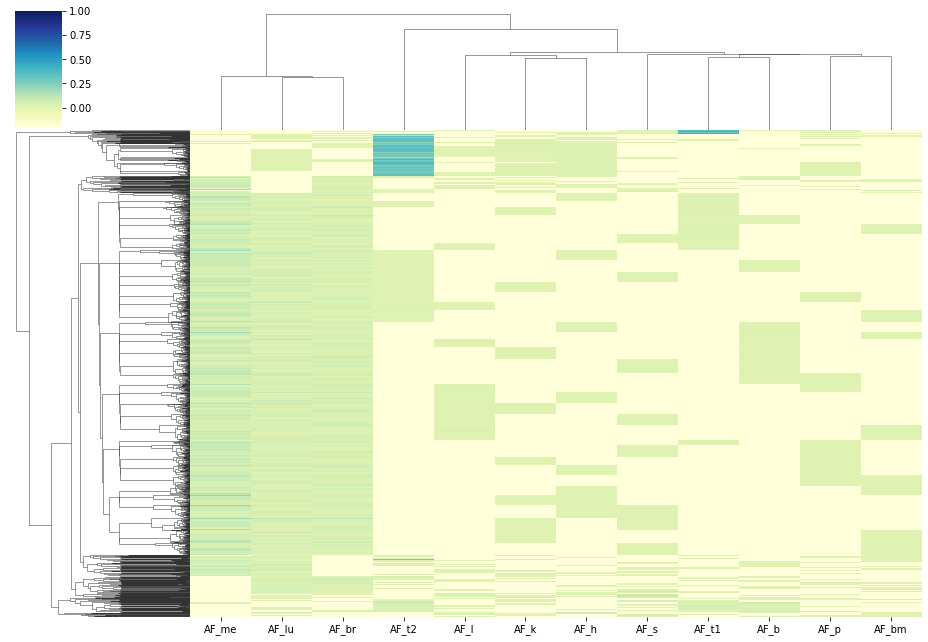

Present in all 6 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


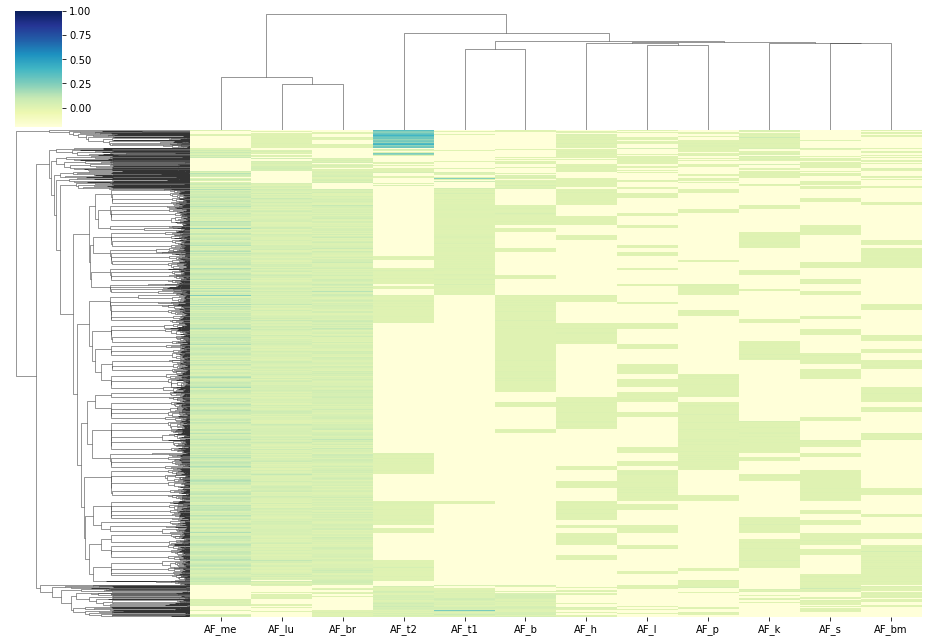

Present in all 7 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


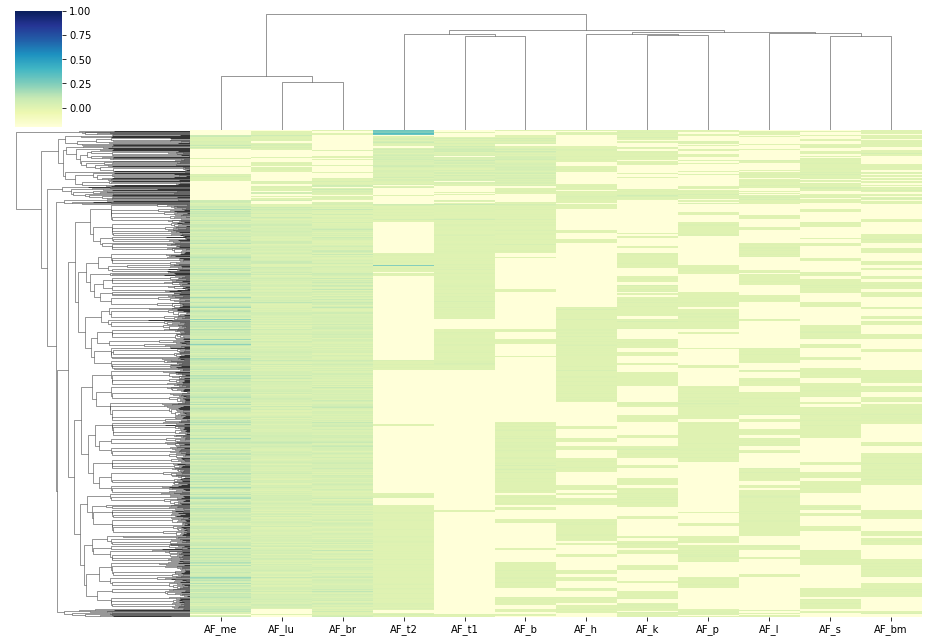

Present in all 8 tissues


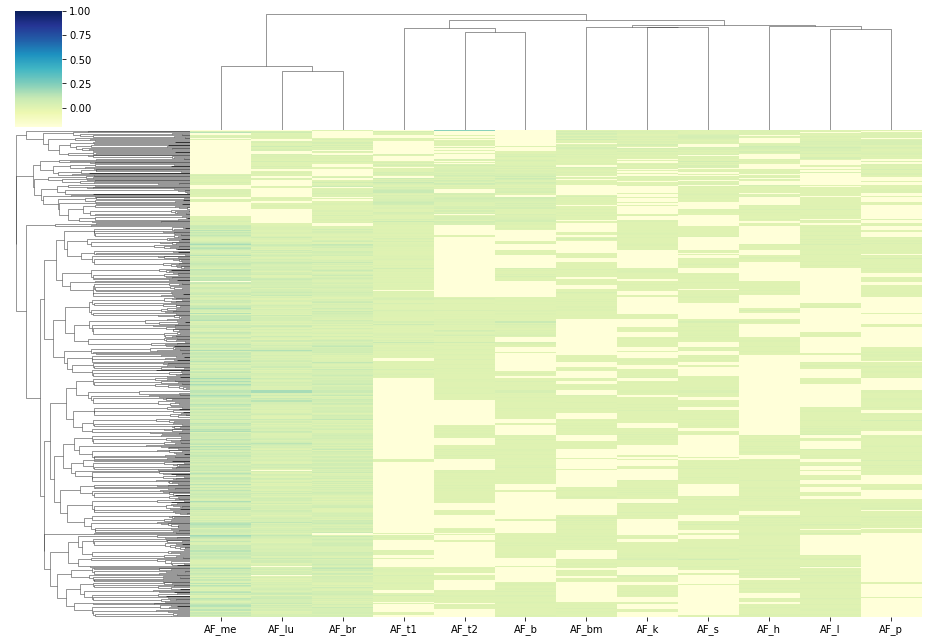

Present in all 9 tissues


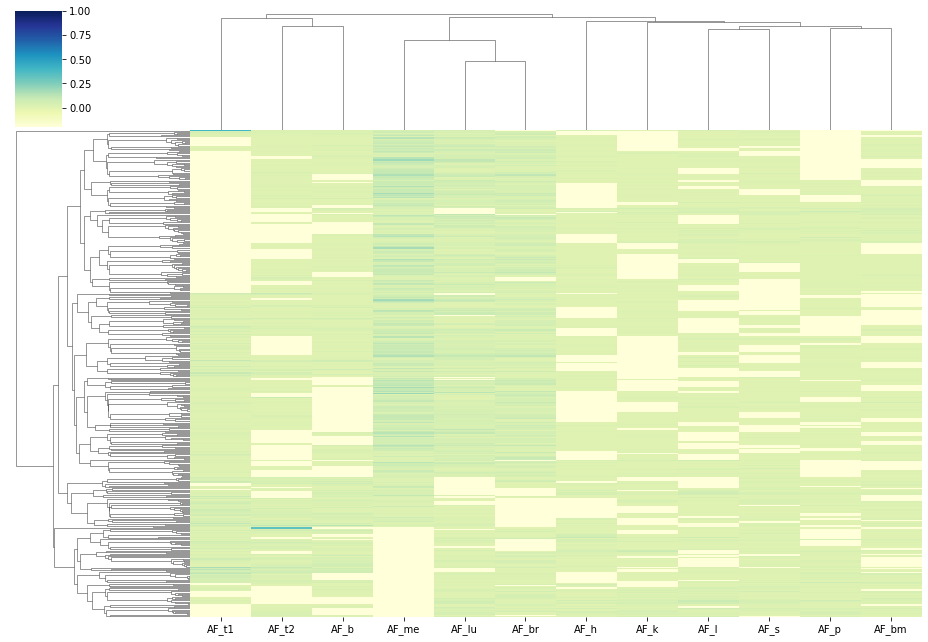

In [92]:
for n in range(1,10):
    print('Present in all',n, 'tissues')
    data = df5[df5['n_tissues']==n].sort_values(by=af_cols,ascending=False)
    data[af_cols] = data[af_cols].replace(0,-0.2)
    if len(data) < 50:
        height = 5
        yticklabels = True
    else:
        height = 9
        yticklabels = False
    sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
    plt.show()

/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


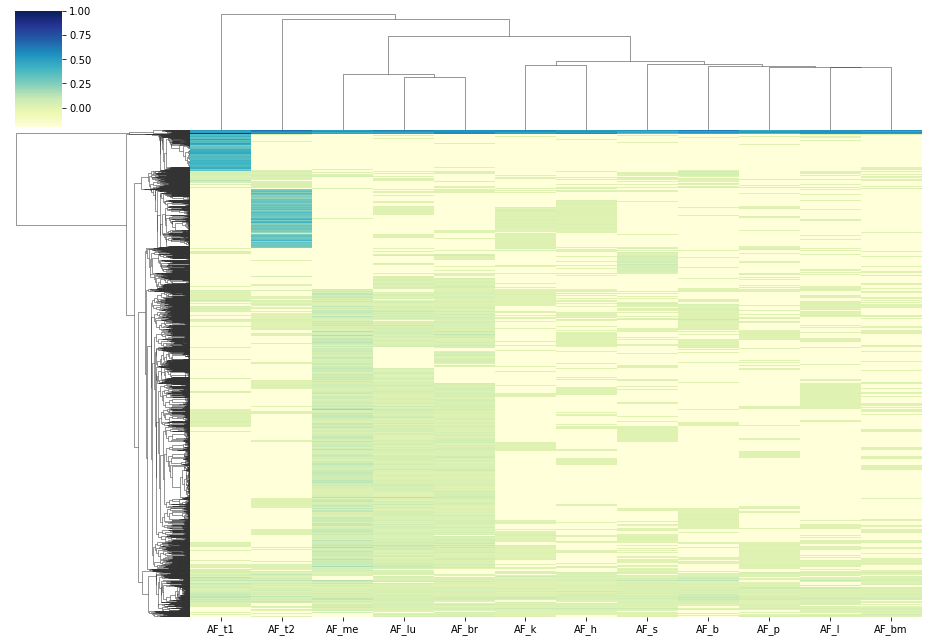

In [122]:
data = df5.sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

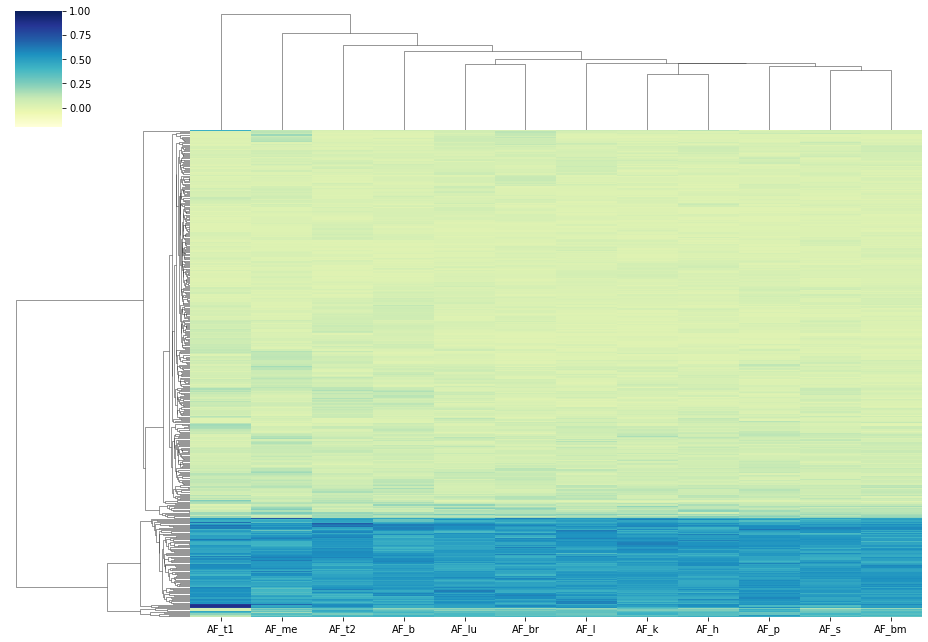

In [123]:
data = df5[df5['n_tissues']==12].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

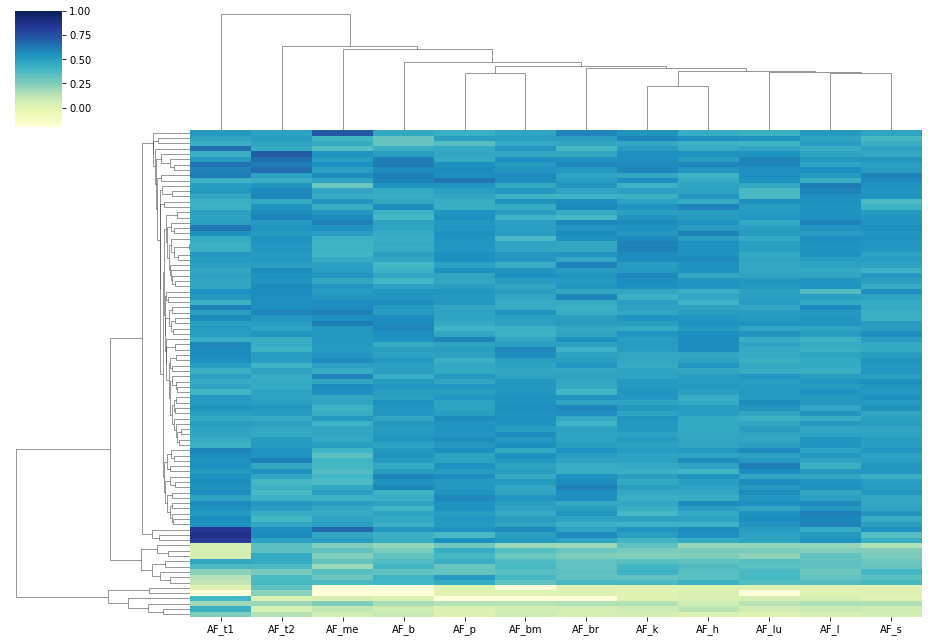

In [119]:

data = df5[(df5['n_tissues']>=8)&((df15['AF_t1']>0.25)|(df15['AF_t2']>0.2))].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

### Check threshold of 2 mutations

Present in all 1 tissues


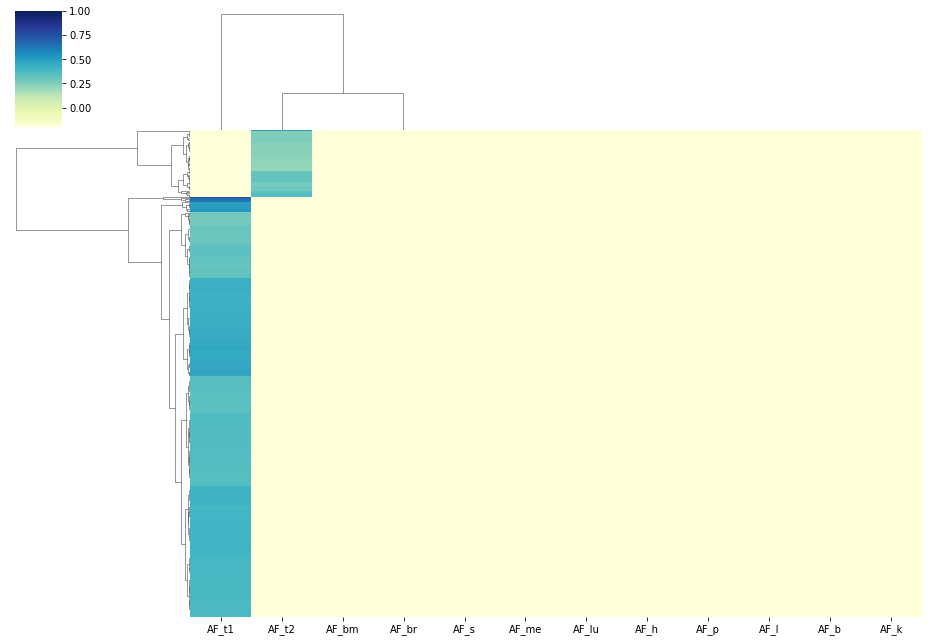

Present in all 2 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


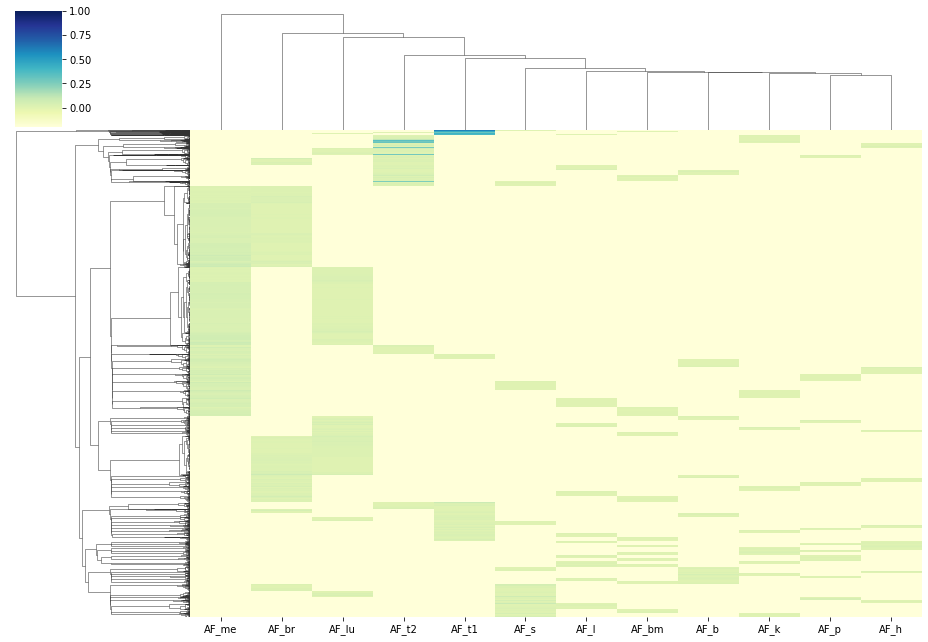

Present in all 3 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


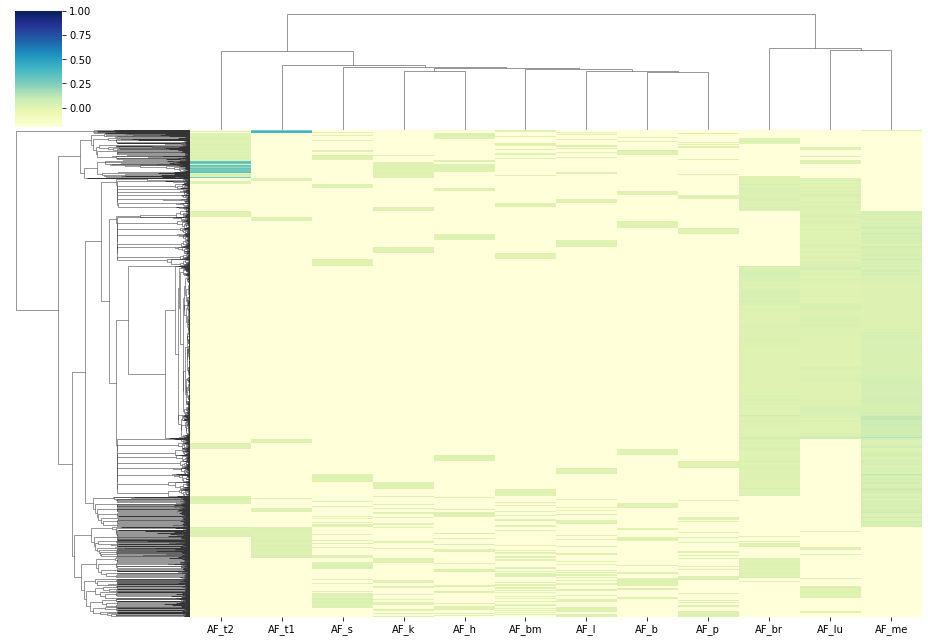

Present in all 4 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


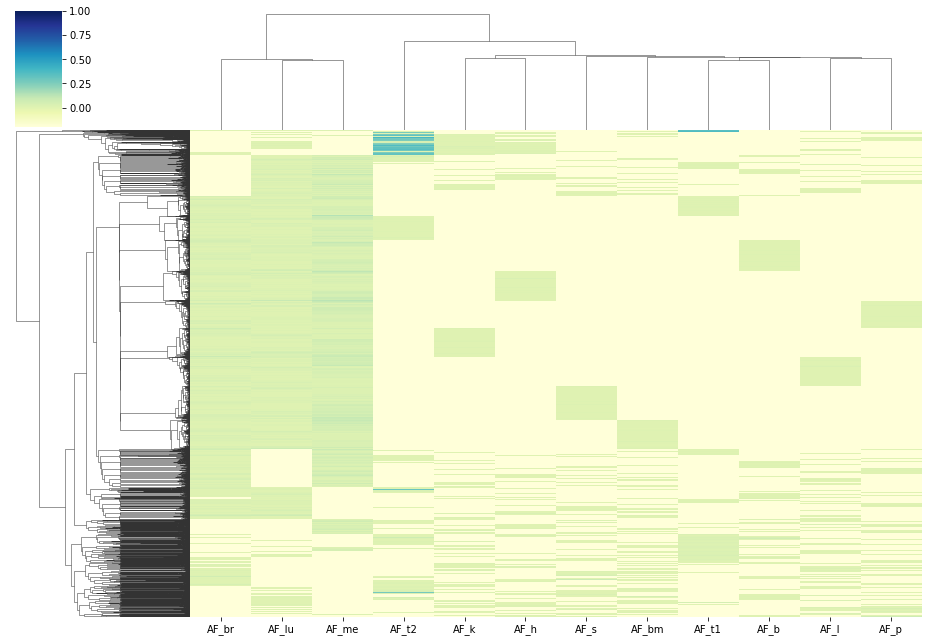

Present in all 5 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


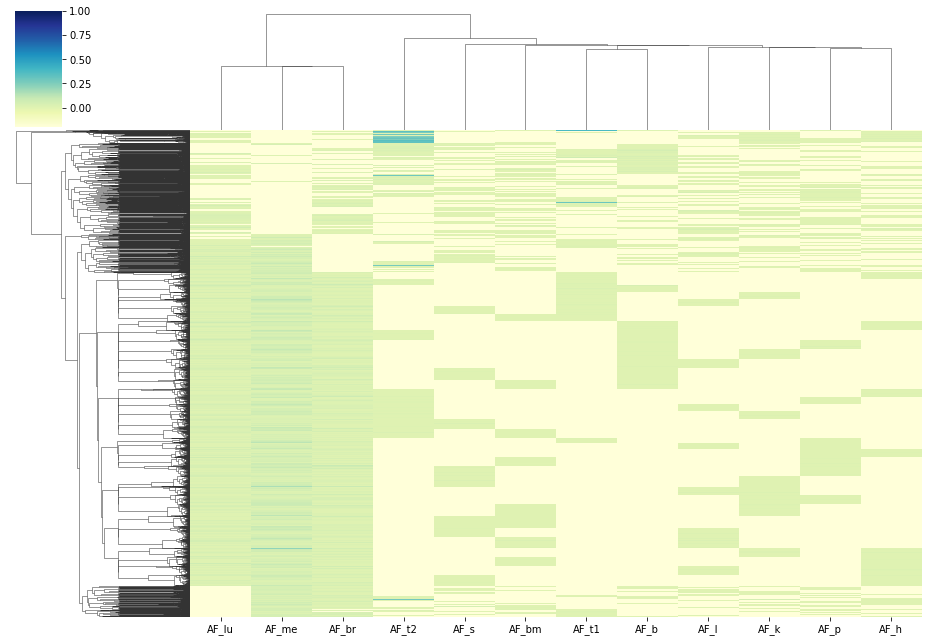

Present in all 6 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


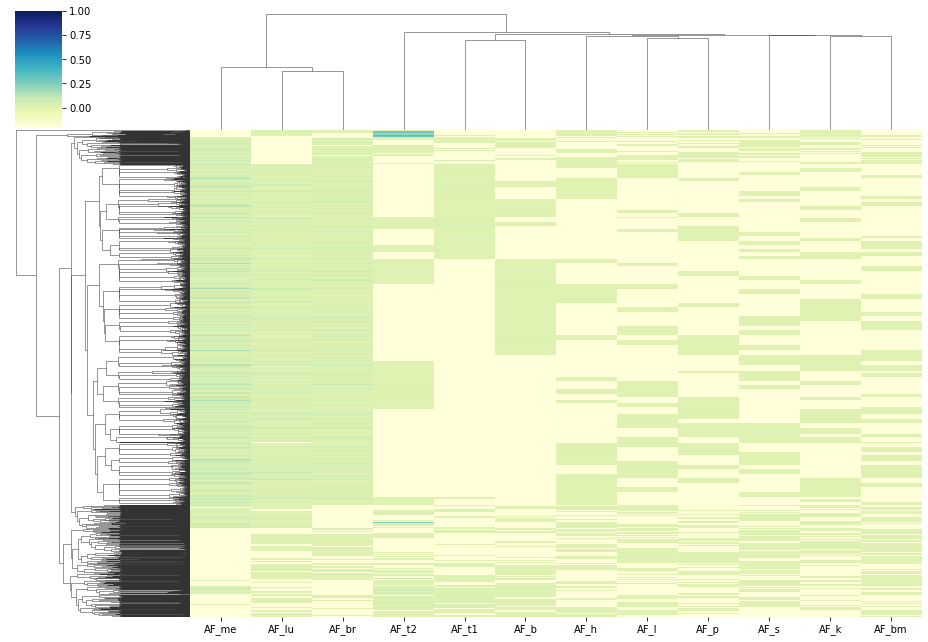

Present in all 7 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


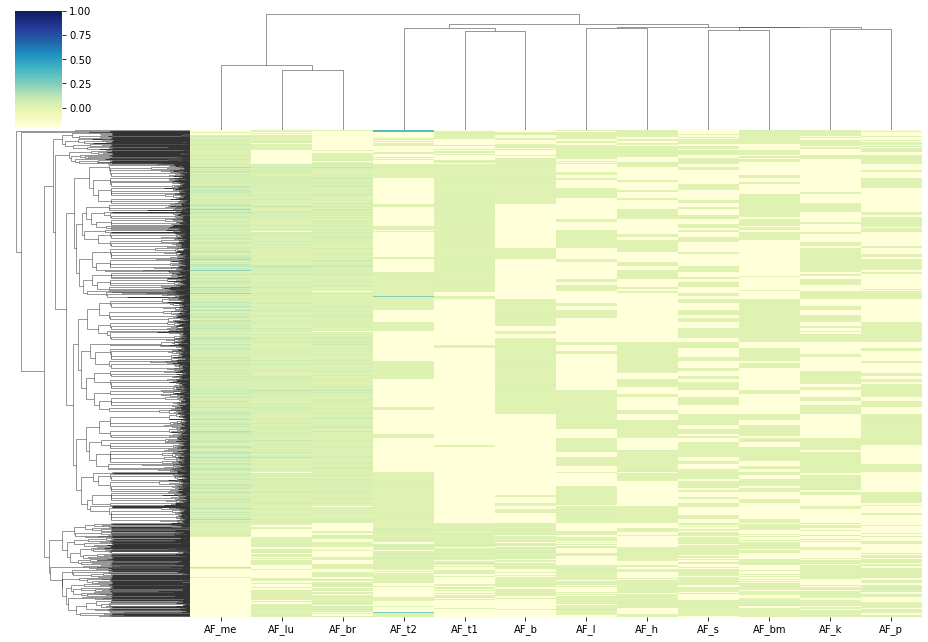

Present in all 8 tissues


/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


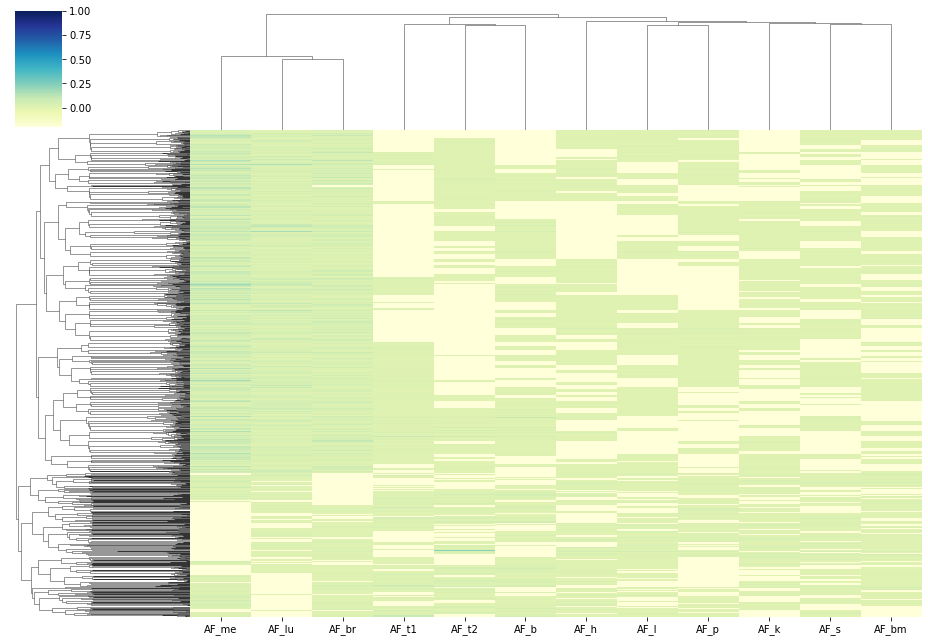

Present in all 9 tissues


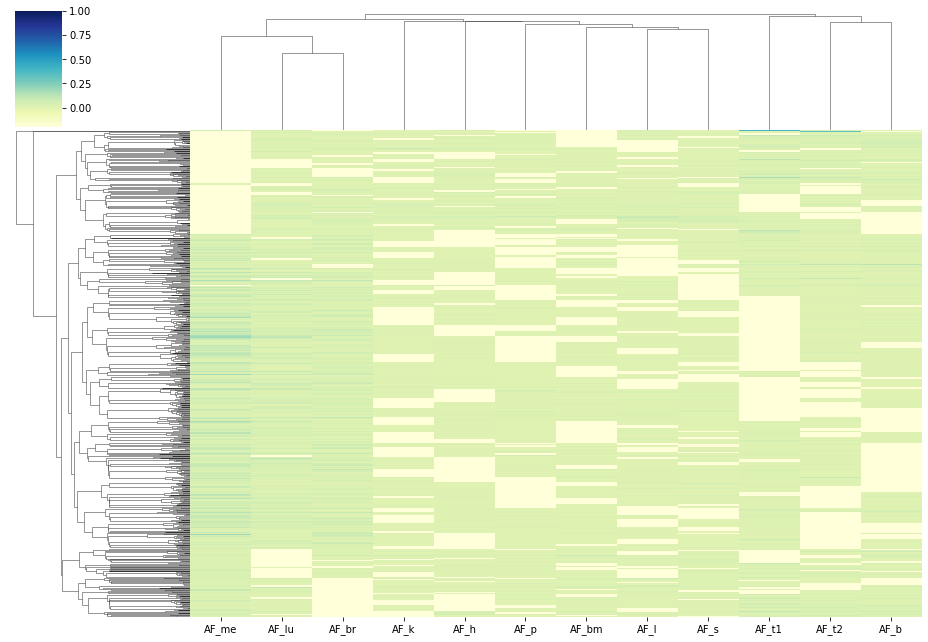

In [93]:
for n in range(1,10):
    print('Present in all',n, 'tissues')
    data = df2[df2['n_tissues']==n].sort_values(by=af_cols,ascending=False)
    data[af_cols] = data[af_cols].replace(0,-0.2)
    if len(data) < 50:
        height = 5
        yticklabels = True
    else:
        height = 9
        yticklabels = False
    sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
    plt.show()

/home/msanchezg/miniconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


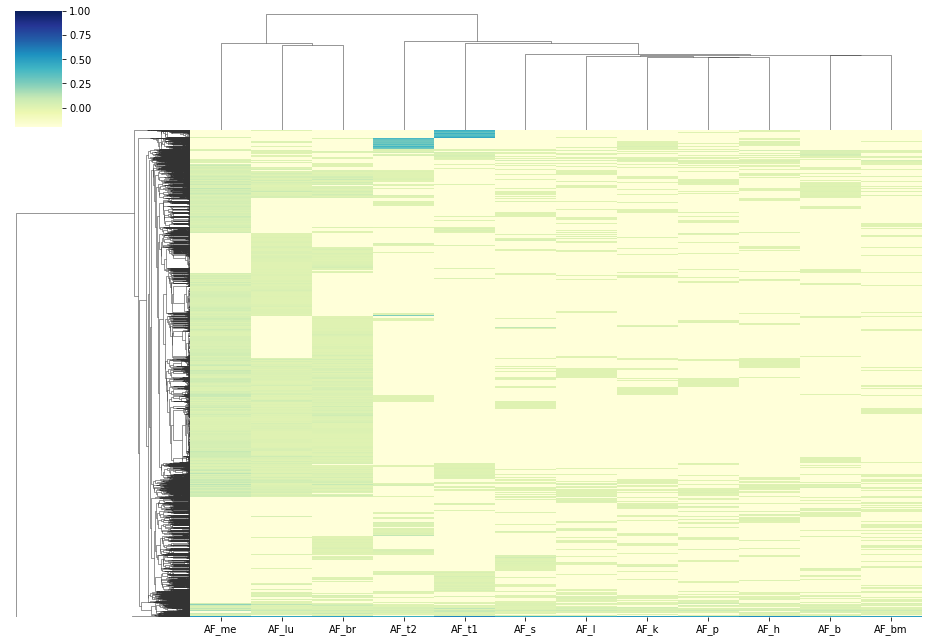

In [124]:
data = df2.sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

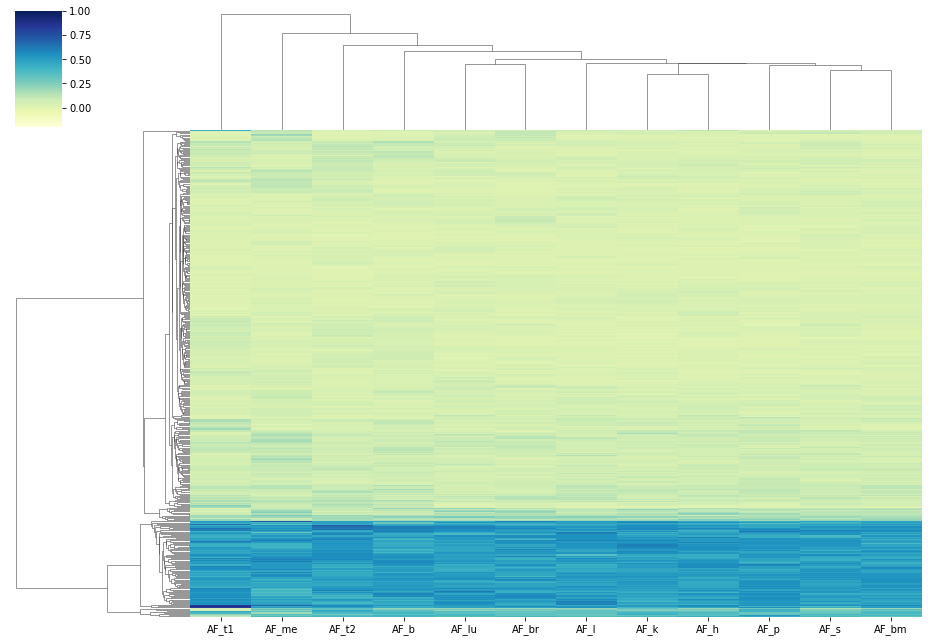

In [125]:
data = df2[df2['n_tissues']==12].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

Present in all 10 tissues


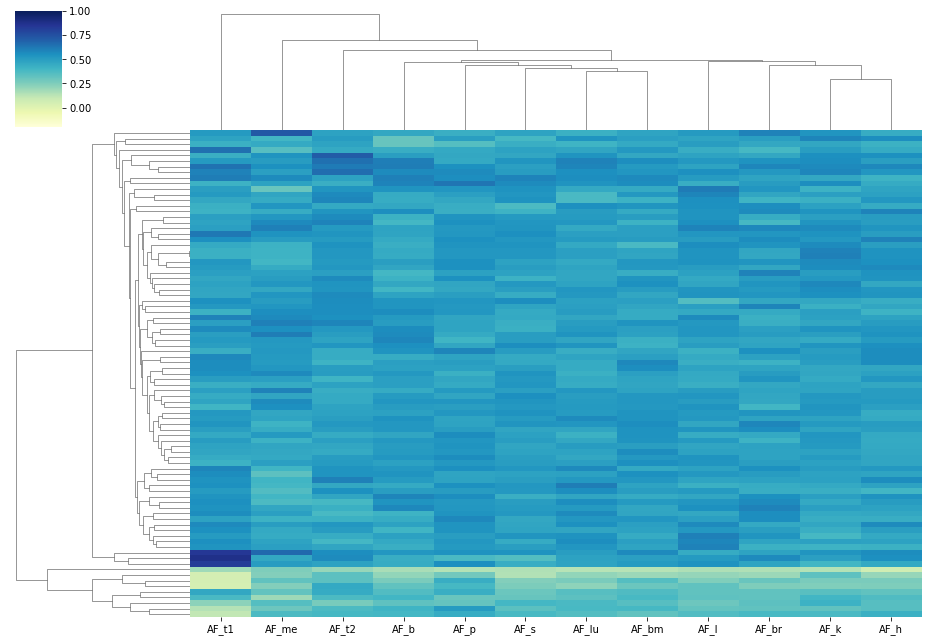

In [127]:
#Clonal in Tumor2
n=10
print('Present in all',n, 'tissues')
data = df15[(df15['n_tissues']>=n)&(df15['AF_t2']>0.2)].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

Present in all 1 tissues


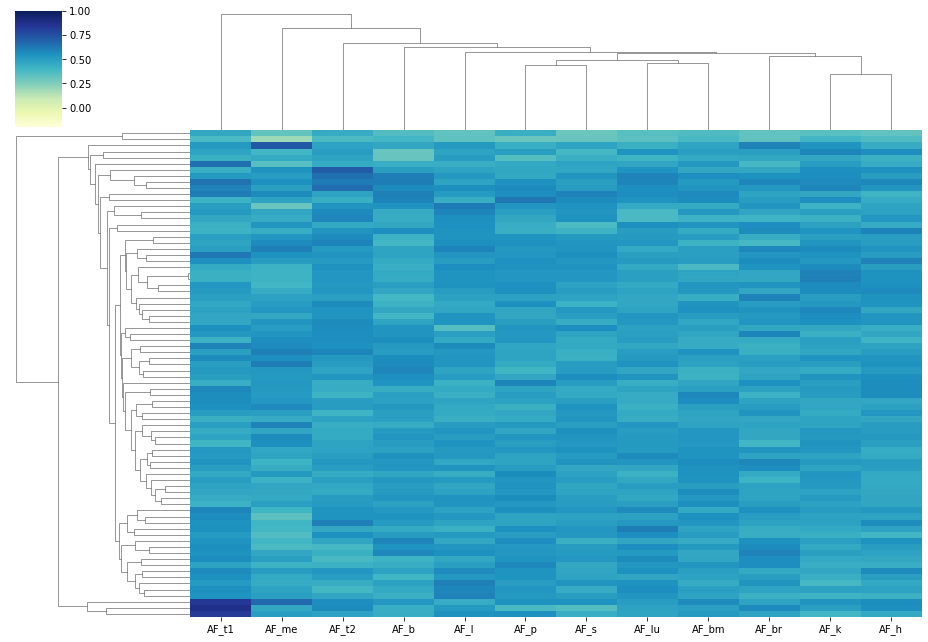

In [128]:
#clonal in Tumor1 and Tumor2
n=1
print('Present in all',n, 'tissues')
data = df15[(df15['n_tissues']>=n)&(df15['AF_t1']>0.25)&(df15['AF_t2']>0.2)].sort_values(by=af_cols,ascending=False)
data[af_cols] = data[af_cols].replace(0,-0.2)
yticklabels = False
sns.clustermap(data[af_cols],cmap="YlGnBu",figsize=((len(tissues)+1),height),vmin=-0.2,vmax=1,yticklabels=yticklabels)
plt.show()

### Save table with filtered artifacts

Minimum number of 15 reads seems reasonable to eliminate artifacts that are not in the cohort.\
With lower thresholds, there are many mutations suspected to be artifacts

In [98]:
df15.to_csv('./output/somatic_filtered_artifacts.tsv.gz',index=None,compression='gzip',sep='\t')

In [100]:
#count clonal mutations in tumor1
df15[df15['AF_t1']>0.25].groupby('mut_type').count()

,CHROM,POS,REF,ALT,parents,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
mut_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
indel,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0,0,0,0,0,0,0,0,0,0,0,40,40,0,0,0,0,0,0,0,0,0,0,0,0,40,40,40,40
snv,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,908,4,4,4,4,4,4,4,4,4,4,4,4,908,908,4,4,4,4,4,4,4,4,4,4,4,4,908,908,908,908


In [99]:
#count clonal mutations in tumor2
df15[df15['AF_t2']>0.2].groupby('mut_type').count()

,CHROM,POS,REF,ALT,parents,depth_t1,depth_t2,depth_b,depth_k,depth_l,depth_p,depth_h,depth_lu,depth_me,depth_s,depth_br,depth_bm,filter_depth_t1,filter_depth_t2,filter_depth_b,filter_depth_k,filter_depth_l,filter_depth_p,filter_depth_h,filter_depth_lu,filter_depth_me,filter_depth_s,filter_depth_br,filter_depth_bm,filter_depth_all,AF_t1,ref_reads_t1,alt_reads_t1,DP_t1,AF_t2,ref_reads_t2,alt_reads_t2,DP_t2,AF_b,ref_reads_b,alt_reads_b,DP_b,AF_k,ref_reads_k,alt_reads_k,DP_k,AF_l,ref_reads_l,alt_reads_l,DP_l,AF_p,ref_reads_p,alt_reads_p,DP_p,AF_h,ref_reads_h,alt_reads_h,DP_h,AF_lu,ref_reads_lu,alt_reads_lu,DP_lu,AF_me,ref_reads_me,alt_reads_me,DP_me,AF_s,ref_reads_s,alt_reads_s,DP_s,AF_br,ref_reads_br,alt_reads_br,DP_br,AF_bm,ref_reads_bm,alt_reads_bm,DP_bm,AF_m,ref_reads_m,alt_reads_m,DP_m,AF_f,ref_reads_f,alt_reads_f,DP_f,tumor1,tumor2,blood,kidney,liver,pancreas,heart,lung,medulla,spleen,brain,bma,mother,father,n_tissues,chromosome,start,end,allele,strand,#Uploaded_variation,Location,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,IMPACT,DISTANCE,STRAND,FLAGS,SYMBOL,SYMBOL_SOURCE,HGNC_ID,CANONICAL,ENSP,SOURCE,AFR_AF,AMR_AF,EAS_AF,EUR_AF,SAS_AF,CLIN_SIG,SOMATIC,PHENO,gnomADg,gnomADg_AF,gnomADg_NFE,Change,alt_reads_b2,alt_reads_b3,alt_reads_b4,alt_reads_b5,alt_reads_b6,alt_reads_b7,alt_reads_b8,alt_reads_b9,alt_reads_b10,alt_reads_b11,alt_reads_b12,alt_reads_b13,alt_reads_b14,alt_reads_b15,alt_reads_b16,alt_reads_b17,alt_reads_b18,alt_reads_b19,alt_reads_b20,alt_reads_b21,alt_reads_b22,alt_reads_b23,alt_reads_b24,alt_reads_b25,alt_reads_b26,pval_sa_t1,pval_sa_t2,pval_sa_b,pval_sa_k,pval_sa_l,pval_sa_p,pval_sa_h,pval_sa_lu,pval_sa_me,pval_sa_s,pval_sa_br,pval_sa_bm,present_at_cohort,present_at_all_bloods,qval_sa_t1,qval_sa_t2,qval_sa_b,qval_sa_k,qval_sa_l,qval_sa_p,qval_sa_h,qval_sa_lu,qval_sa_me,qval_sa_s,qval_sa_br,qval_sa_bm,sequencing_artifact_min15,sequencing_artifact_min10,sequencing_artifact_min5,sequencing_artifact_min2
mut_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
indel,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,151,0,0,0,0,0,0,0,0,0,0,0,0,151,151,0,0,0,0,0,0,0,0,0,0,0,0,151,151,151,151
snv,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,1263,4,4,4,4,4,4,4,4,4,4,4,4,1263,1263,4,4,4,4,4,4,4,4,4,4,4,4,1263,1263,1263,1263
